In [1]:
import numpy as np
#import tensorflow as tf
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.io.fits import getheader
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import mpyfit
from astropy.io import fits
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import csv
import pickle
import math as m
import os
import pandas as pd
import mpyfit
import datetime
from astropy.time import Time

from tqdm import tqdm
# check headers

In [2]:
# define function that converts bjd dates to UTC times
def time_bjd_isot(time_array):
    tm = Time(time_array-2400000, format='mjd')
    return tm.isot


In [3]:
#year = "2016"
#
# list the directories that have HARPS-N files in them
#directories = os.listdir('DRS-2.3.1/reduced/hpcstorage'+str(year))

# Open csv file with DRS RVs
df = pd.read_csv('Sun_harpn_2-3-1_alldata_quality_extinct_corrections.csv')
#df_flags = pd.read_excel("Sun_harpsn_qualflag.xlsx")


#print(np.mean(df["rvheli"]))
#print(np.std(df["rvheli"]))

#hdul = fits.open('DRS-2.3.1/reduced/hpcstorage'+str(year)+"/2016-01-01/test.fits", memmap=False)
df.columns

Index(['root', 'bjd', 'rvraw', 'rvheli', 'rvfinal', 'erv', 'fwhm', 'fwhmcor',
       'efwhm', 'contrast', 'contrastcor', 'econtrast', 'asym', 'easym',
       'bisspan', 'ebisspan', 'exptime', 'airmass', 'sn10', 'sn50', 'sn60',
       'expmetermean', 'expmetermin', 'expmetermax', 'expmeterstd', 'quality',
       'k60', 'ek60', 'nrdayobs', 'rvSS', 'rvext'],
      dtype='object')

original, num of bjds: 863
extinction, num of bjds: 801
qflag_cut, num of bjds: 655


863

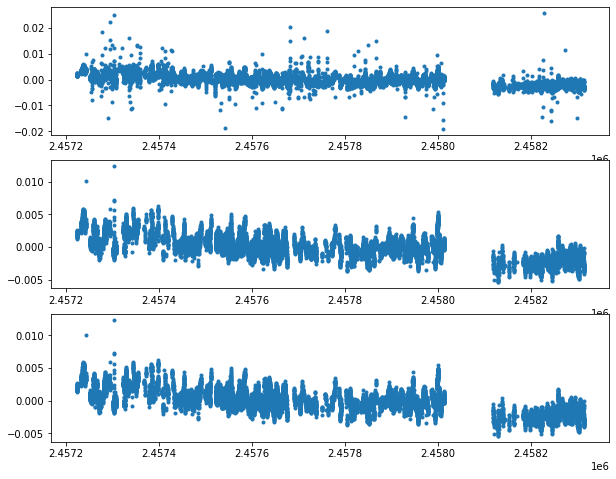

In [18]:
# Remove BJD after 2458315.044551722

bjd_df = df[df['bjd']<2458315.044551722]
print("original, num of bjds: "+str(len(np.unique(np.floor(bjd_df['bjd'])))))

# Check whether extinction is greater than 0.1 m/s
extinction_df = bjd_df[np.abs((bjd_df['rvext']-np.mean(bjd_df['rvext']))*1000)<0.1]

print("extinction, num of bjds: "+str(len(np.unique(np.floor(extinction_df['bjd'])))))

#  Check whether quality flag > 0.99
qualflag_df = extinction_df[extinction_df['quality']>0.99]

print("qflag_cut, num of bjds: "+str(len(np.unique(np.floor(qualflag_df['bjd'])))))

final_df = qualflag_df.reset_index()


fig, ax = plt.subplots(3,1, figsize=(10, 8))
#ax[0].plot(bjd_df["bjd"],(bjd_df['rvext']-np.mean(bjd_df['rvext']))*1000, ".", zorder=0)
#ax[0].hlines(y=0.1, xmin=np.min(bjd_df["bjd"]), xmax = np.max(bjd_df["bjd"]), color='r',zorder=1)
#ax[0].hlines(y=-0.1, xmin=np.min(bjd_df["bjd"]), xmax = np.max(bjd_df["bjd"]), color='r',zorder=1)

ax[0].plot(extinction_df["bjd"],(extinction_df["rvfinal"]-np.mean(extinction_df["rvfinal"])), ".")
ax[1].plot(qualflag_df["bjd"],(qualflag_df["rvfinal"]-np.mean(qualflag_df["rvfinal"])), ".")
ax[2].plot(final_df["bjd"],(final_df["rvfinal"]-np.mean(final_df["rvfinal"])), ".")


#bjd_df = final_df[final_df['bjd']<2458315.044551722]

len(np.unique(np.floor(bjd_df['bjd'])))

In [5]:
year = '2016'
directories = os.listdir('DRS-2.3.1/reduced/hpcstorage'+year)
files = os.listdir(str('DRS-2.3.1/reduced/hpcstorage'+str(year)+"/"+directories[0]))

hdul = fits.open(str('DRS-2.3.1/reduced/hpcstorage'+year+"/"+directories[0]+"/"+files[0]), memmap=False)
print('bjd: '+str(hdul[0].header['HIERARCH TNG QC BJD']))
hdul[0].header['HIERARCH TNG QC CCF RV']
hdul[0].header['HIERARCH TNG QC BERV']

hdul[0].header

bjd: 2457450.94904415


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2021-07-20T08:47:00' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
VERSION =               120203 / Application parameter value                    
DWELL   =               300000 / Application parameter value                    
RD_TIME =                    0 / Application parameter value                    
RS_TIME =                  383 / Application parameter value                    
FRM_TYPE=                    1 / Application parameter value                    
NUM_EXPS=                   

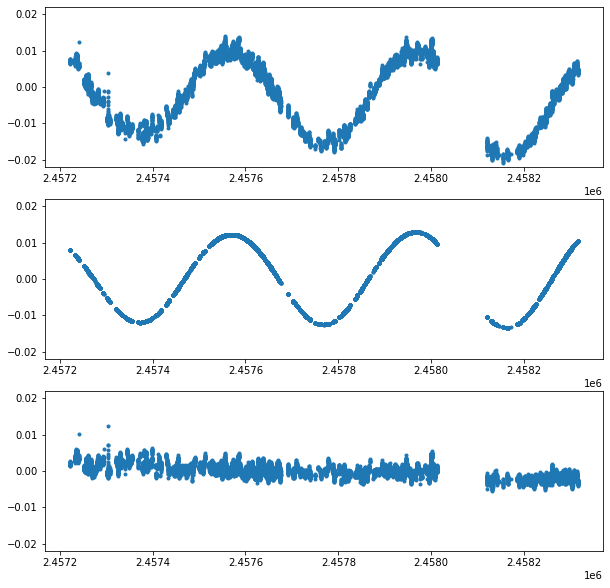

In [6]:
fig, ax = plt.subplots(3,1, figsize=(10, 10))
ax[0].plot(final_df["bjd"],(final_df["rvraw"]-np.mean(final_df["rvraw"])), ".")
ax[1].plot(final_df["bjd"],(final_df["rvraw"]-final_df["rvheli"]), ".")
ax[2].plot(final_df["bjd"],(final_df["rvfinal"]-np.mean(final_df["rvfinal"])), ".")

for i in [0,1,2]:
    ax[i].set_ylim(-0.022, 0.022)
    
# clipping 

In [36]:
rerun = False

In [39]:
# DO NOT RUN THIS CELL UNLESS YOU NEED TO REGENERATE THE NPZ FILES

if rerun == True:
    missing_dates = []
    full_bjd_list = []
    qflag_bjd_list_diff = []

    # master param lists of daily (d) averages
    d_normalized_ccf_list = []
    d_bjd_list = []
    d_rvh_list = []
    d_sig_vrad_list = []
    d_berv_list = []
    d_fwhm_list = []
    d_sig_fwhm_list = []
    d_cont_list = []
    d_sig_contrast_list = []
    d_bis_list = []
    d_sig_bis_span_list = []
    d_qflag_list = []


    removed_counter = 0
    qflag_removed_counter = 0
    diff_ext_removed_counter = 0
    ccf_counter = 0
    gen_counter = 0
    #fig, ax = plt.subplots(figsize=(10, 7))
    #fig3, ax3 = plt.subplots(figsize=(10, 7))

    for year in ['2015','2016', '2017','2018half']:
        # list the directories that have HARPS-N files in them
        directories = os.listdir('DRS-2.3.1/reduced/hpcstorage'+year)

        for j in tqdm(range(len(directories))):
            #for directory in directories:
            directory = directories[j]
            if directory == '.DS_Store':
                continue
            #print(directory)
            files = os.listdir(str('DRS-2.3.1/reduced/hpcstorage'+str(year)+"/"+directory))

            rv_axis = np.linspace(-20,20, 161)

            bjd_list =[]
            ccf_list = []
            DRS_qflag_list = []
            DRS_new_fwhm_list = []
            DRS_new_contrast_list = []
            DRS_new_vrad_list = []
            DRS_new_berv_list = []
            DRS_vrad_raw_list = []
            DRS_new_bis_span_list = []

            DRS_new_sig_vrad_list = []
            DRS_new_sig_fwhm_list = []
            DRS_new_sig_contrast_list = []
            DRS_new_sig_bis_span_list = []

            DRS_weight_new_sig_vrad_list = []
            DRS_weight_new_sig_fwhm_list = []
            DRS_weight_new_sig_contrast_list = []
            DRS_weight_new_sig_bis_span_list = []

            for file in files:
                if file == '.DS_Store':
                    continue
                #print("file = "+str(file))
                ccf_counter += 1
                hdul = fits.open(str('DRS-2.3.1/reduced/hpcstorage'+str(year)+"/"+directory+"/"+file), memmap=False)
                ccf = hdul[1].data[69]
                bjd = hdul[0].header["HIERARCH TNG QC BJD"]

                new_bjd_list = pd.Index(final_df['bjd'])
                i = new_bjd_list.get_loc(bjd, method = "nearest", tolerance=10000)
                #print(np.abs(df['new_bjd'][i]))

                # Check that the BJD is within 10 seconds (0.000115741 days)
                if (np.abs(final_df['bjd'][i]-bjd)) > 0.000115741:
                    #print("the difference in BJD is more than 10 seconds for BJD: "+str(bjd))
                    removed_counter +=1
                    continue

                DRS_new_vrad= final_df['rvfinal'][i] #hdul[0].header['HIERARCH TNG QC CCF RV'] 
                DRS_new_berv= final_df['rvSS'][i]
                DRS_new_sig_vrad = final_df['erv'][i]
                DRS_weight_new_sig_vrad = 1/(DRS_new_sig_vrad)**2
                DRS_new_fwhm = hdul[0].header["HIERARCH TNG QC CCF FWHM"]
                DRS_new_sig_fwhm = hdul[0].header["HIERARCH TNG QC CCF FWHM ERROR"]
                DRS_weight_new_sig_fwhm = 1/ (DRS_new_sig_fwhm)**2
                DRS_new_contrast = hdul[0].header["HIERARCH TNG QC CCF CONTRAST"]
                DRS_new_sig_contrast = hdul[0].header["HIERARCH TNG QC CCF CONTRAST ERROR"]
                DRS_weight_new_sig_contrast = 1/(DRS_new_sig_contrast)**2
                DRS_new_bis_span = hdul[0].header["HIERARCH TNG QC CCF BIS SPAN"]
                DRS_new_sig_bis_span = hdul[0].header["HIERARCH TNG QC CCF BIS SPAN ERROR"]
                DRS_weight_new_sig_bis_span = 1/(DRS_new_sig_bis_span)**2


                # check that the qflag is >0.99
                #qflag_bjd = bjd#- 2400000
                #qflag_bjd_diff = np.abs(df['bjd'][i]-qflag_bjd)

                DRS_qflag = final_df["quality"][i]
                #if qflag_bjd_diff > 0.00081 or DRS_qflag <0.99:
                #    #print("the difference in BJD is more than 10 seconds for BJD: "+str(bjd))
                #    #print(str(i)+", qflag: "+str(DRS_qflag)+" is less than 0.99")
                #    qflag_removed_counter += 1
                #    continue
                #print("found some qflag>0.99")

                # Check that the differential extinction is less than 10 cm/s
                #diff_ext = df['rvext'][i]*10
                #if diff_ext > 0.1:
                #    diff_ext_removed_counter += 1
                #    continue

                #qflag_bjd_list_diff.append(qflag_bjd_diff)

                ccf_list.append(ccf)
                bjd_list.append(bjd)

                # append values from DRS
                DRS_qflag_list.append(DRS_qflag)
                DRS_new_fwhm_list.append(DRS_new_fwhm)
                DRS_new_contrast_list.append(DRS_new_contrast)
                DRS_new_vrad_list.append(DRS_new_vrad)
                DRS_new_berv_list.append(DRS_new_berv)
                #DRS_vrad_raw_list.append(DRS_vrad_raw)
                DRS_new_bis_span_list.append(DRS_new_bis_span)

                # append sig from DRS
                DRS_new_sig_vrad_list.append(DRS_new_sig_vrad)
                DRS_new_sig_fwhm_list.append(DRS_new_sig_fwhm)
                DRS_new_sig_contrast_list.append(DRS_new_sig_contrast)
                DRS_new_sig_bis_span_list.append(DRS_new_sig_bis_span)

                # append weights from DRS
                DRS_weight_new_sig_vrad_list.append(DRS_weight_new_sig_vrad)
                DRS_weight_new_sig_fwhm_list.append(DRS_weight_new_sig_fwhm)
                DRS_weight_new_sig_contrast_list.append(DRS_weight_new_sig_contrast)
                DRS_weight_new_sig_bis_span_list.append(DRS_weight_new_sig_bis_span)

            if not ccf_list:
                #print("There are no DRS RVs on "+str(directory))
                #print(str(directory))
                missing_dates.append(directory)
                continue
            # take the (weighted) averages for that day of observations
            mean_ccf = np.mean(ccf_list, axis=0)
            median_DRS_qflag = np.mean(DRS_qflag_list)
            median_DRS_new_fwhm = np.average(DRS_new_fwhm_list, weights = DRS_weight_new_sig_fwhm_list)
            median_DRS_new_contrast = np.average(DRS_new_contrast_list, weights = DRS_weight_new_sig_contrast_list)
            median_DRS_new_vrad = np.average(DRS_new_vrad_list, weights=DRS_weight_new_sig_vrad_list)
            median_DRS_new_berv = np.mean(DRS_new_berv_list) #no weights exist
            #median_DRS_vrad_raw = np.mean(DRS_vrad_raw_list) #no weights exist
            median_DRS_new_bis_span = np.average(DRS_new_bis_span_list, weights= DRS_weight_new_sig_bis_span_list)
            median_bjd = np.mean(bjd_list)

            # averages for errors
            median_sig_vrad = np.mean(DRS_weight_new_sig_vrad_list)
            median_sig_fwhm = np.mean(DRS_weight_new_sig_fwhm_list)
            median_sig_contrast = np.mean(DRS_weight_new_sig_contrast_list)
            median_sig_bis_span = np.mean(DRS_weight_new_sig_bis_span_list)

            #ax.plot(rv_axis,ccf, label = "all ccf's", color= 'b')
            #ax.plot(rv_axis,mean_ccf, label = "mean ccf, "+str(median_bjd), color= 'r')
            #ax.set_xlabel("RV (m/s)", size =15)
            #ax.set_ylabel("CCF", size =15)
            #ax.legend()

            #print(median_bjd)
            #print(median_DRS_new_vrad)

            #fig2, ax2 = plt.subplots(figsize=(10, 7))
            x_mean = [median_DRS_new_vrad]*len(DRS_new_vrad_list)

            # Normalize the CCF
            rv_data = np.linspace(-20, 20, 49)
            x = np.where(abs(rv_data) > 10)
            non_peak = mean_ccf[x]
            p3guess = np.median(non_peak)
            normalized_ccf =(mean_ccf/p3guess)

            # create master list of params required per day
            d_normalized_ccf_list.append(normalized_ccf)
            d_bjd_list.append(median_bjd)
            d_rvh_list.append(median_DRS_new_vrad)
            d_berv_list.append(median_DRS_new_berv)
            d_fwhm_list.append(median_DRS_new_fwhm)
            d_cont_list.append(median_DRS_new_contrast)
            d_bis_list.append(median_DRS_new_bis_span)
            d_qflag_list.append(median_DRS_qflag)

            d_sig_vrad_list.append(median_sig_vrad)
            d_sig_fwhm_list.append(median_sig_fwhm)
            d_sig_contrast_list.append(median_sig_contrast)
            d_sig_bis_span_list.append(median_sig_bis_span)

    # uncomment this line to write files
    #outfile = 'NEW_DRS2_3_1_qual_ext_sigma.npz'
    np.savez(outfile, 
             d_normalized_ccf_list=d_normalized_ccf_list, 
             d_bjd_list=d_bjd_list,
             d_rvh_list= d_rvh_list,
             d_berv_list=d_berv_list,
             d_fwhm_list=d_fwhm_list,
             d_cont_list=d_cont_list,
             d_bis_list=d_bis_list,
             d_qflag_list=d_qflag_list,
             d_sig_vrad_list=d_sig_vrad_list,
             d_sig_fwhm_list=d_sig_fwhm_list,
             d_sig_contrast_list=d_sig_contrast_list,
             d_sig_bis_span_list=d_sig_bis_span_list)
else:
    print("Since rerun == False, the npzfiles were not regenerated")
    



Since rerun == False, the npzfiles were not regenerated


In [10]:
outfile = 'NEW_DRS2_3_1_qual_ext_sigma.npz'

npzfile = np.load(outfile)
npzfile.files

['d_normalized_ccf_list',
 'd_bjd_list',
 'd_rvh_list',
 'd_berv_list',
 'd_fwhm_list',
 'd_cont_list',
 'd_bis_list',
 'd_qflag_list',
 'd_sig_vrad_list',
 'd_sig_fwhm_list',
 'd_sig_contrast_list',
 'd_sig_bis_span_list']

In [11]:
np.where(np.abs(npzfile["d_bjd_list"]-2458206.5)<1)

npzfile["d_bjd_list"][484]

2458206.9886805983

In [12]:
# check which BJDs are now missing

og_bjd = set(np.unique(np.floor(final_df["bjd"])))
new_bjd = set(np.floor(npzfile["d_bjd_list"]))

missing = list(sorted(og_bjd - new_bjd))
time_bjd_isot(np.array(missing))

array(['2015-07-20T00:00:00.000', '2015-07-31T00:00:00.000',
       '2015-08-04T00:00:00.000', '2015-08-06T00:00:00.000',
       '2015-08-17T00:00:00.000', '2015-08-20T00:00:00.000',
       '2015-08-21T00:00:00.000', '2015-08-25T00:00:00.000',
       '2015-09-04T00:00:00.000', '2015-09-20T00:00:00.000',
       '2015-09-27T00:00:00.000', '2015-10-06T00:00:00.000',
       '2015-10-26T00:00:00.000', '2015-10-28T00:00:00.000',
       '2015-11-06T00:00:00.000', '2015-11-20T00:00:00.000',
       '2015-11-23T00:00:00.000', '2016-01-06T00:00:00.000',
       '2016-01-09T00:00:00.000', '2016-01-19T00:00:00.000',
       '2016-01-20T00:00:00.000', '2016-01-25T00:00:00.000',
       '2016-01-30T00:00:00.000', '2016-02-01T00:00:00.000',
       '2016-02-11T00:00:00.000', '2016-02-13T00:00:00.000',
       '2016-02-18T00:00:00.000', '2016-02-28T00:00:00.000',
       '2016-03-02T00:00:00.000', '2016-03-04T00:00:00.000',
       '2016-03-08T00:00:00.000', '2016-03-12T00:00:00.000',
       '2016-03-16T00:00

2015-07-19T23:54:03.645
2018-07-15T23:41:29.850


2458314.987151045

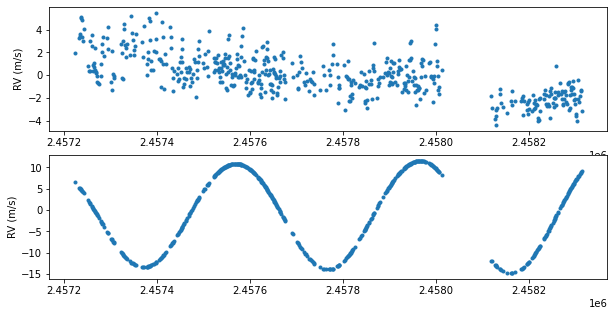

In [13]:
fig, ax = plt.subplots(2,1, figsize=(10, 5))
ax[0].plot(npzfile["d_bjd_list"],(npzfile['d_rvh_list']-np.mean(npzfile['d_rvh_list']))*1000, ".")
ax[0].set_ylabel("RV (m/s)")

ax[1].plot(npzfile["d_bjd_list"],(npzfile['d_berv_list']-np.mean(npzfile['d_berv_list']))*1000, ".")
ax[1].set_ylabel("RV (m/s)")

print(time_bjd_isot(np.min(npzfile['d_bjd_list'])))
print(time_bjd_isot(np.max(npzfile['d_bjd_list'])))
np.max(npzfile['d_bjd_list'])

In [14]:
bjd = npzfile['d_bjd_list']
ccfBary =  npzfile['d_normalized_ccf_list']
rvh = npzfile['d_rvh_list']
bsrv = npzfile['d_berv_list']
fwhm = npzfile['d_fwhm_list']
cont = npzfile['d_fwhm_list']
bis = npzfile['d_bis_list']

## Shift CCFs to zero (no planet injection)

In [27]:
from master_shifting_planet import master_shifting_planet
from mu_plotting import mu_plotting
from residual_plot import residual_plot
#from shifter_fits_maker import shifter_fits_maker
from tf_writer_jul15_21 import tf_writer
from master_shifting import master_shifting

In [28]:
# Define gaussian function
def gauss(x, p):
    return -p[0] * np.exp(-(x - p[1]) ** 2 / (2. * p[2] ** 2)) + p[3]

# A simple minimization function:
def least(p, args):
    x, y = args
    return gauss(x, p) - y

parinfo = [{'fixed': False, 'step': 1e-7},
           {'fixed': False, 'step': 1e-5},
           {'fixed': False, 'step': 1e-4},
           {'fixed': False, 'step': 1e-9}]

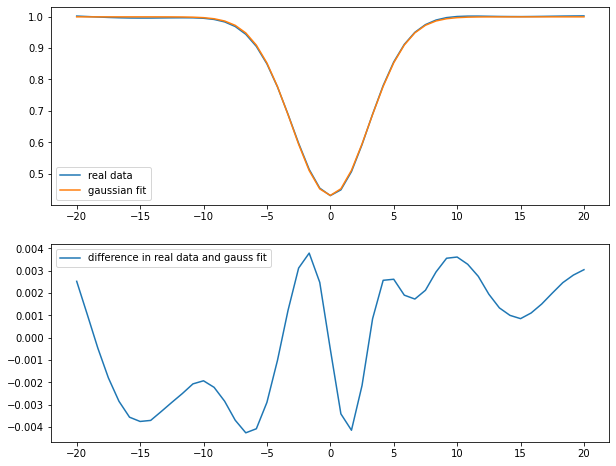

In [29]:
# Test initial fitting params
rv_data = np.linspace(-20, 20, len(ccfBary[0]))
CCF_data = ccfBary
p_no = [0.6, 0.0, 2.7, 1.0]

fig, ax = plt.subplots(2,1, figsize=(10, 8))
#plt.plot(rv_data, gauss(rv_data,p_no_shifted), label='gaussian guess')
ax[0].plot(rv_data, CCF_data[0], label='real data')

pfit_no_shift, results_no_shift = mpyfit.fit(least, p_no, (rv_data, CCF_data[0]), parinfo)
mu_og = pfit_no_shift[1]

ax[0].plot(rv_data, gauss(rv_data,pfit_no_shift), label='gaussian fit')
ax[0].legend()


ax[1].plot(rv_data, CCF_data[0]-gauss(rv_data,pfit_no_shift), label='difference in real data and gauss fit')
ax[1].legend()


0.0 1.0
0.0 1.0
0.0 1.0


,BJD,vrad_star,og_ccf_list,jup_shifted_CCF_data_list,zero_shifted_CCF_list,CCF_normalized_list,CCF_normalized_list_cutoff,mu_og_list,mu_jup_list,mu_zero_list,fwhm,cont,bis,shift_by_rv
0,2.457328e+06,0.105097,"[1.0015097, 1.0000265, 0.9985184, 0.99718356, ...","[1.0015256685219212, 1.000043076973615, 0.9985...","[1.0016871020475215, 1.0002211098754359, 0.998...","[1.1526482767369668, 1.1509613494046589, 1.149...","[1.1509613494046589, 1.1492163581416386, 1.147...",-0.004052,0.005064,0.102135,7.034716,7.034716,-0.064548,mpyfit_rvs
1,2.457333e+06,0.103722,"[1.0014056, 0.99990964, 0.99838215, 0.99708915...","[1.0014226531348134, 0.9999275732263389, 0.998...","[1.0015825136892071, 1.0001120941825514, 0.998...","[1.1524775681172361, 1.1507856201509115, 1.149...","[1.1507856201509115, 1.1490124823740788, 1.147...",-0.006036,0.003648,0.102025,7.036466,7.036466,-0.061424,mpyfit_rvs
2,2.457378e+06,0.103140,"[1.0013633, 0.9999264, 0.9984147, 0.99699295, ...","[1.0013831531975375, 0.9999475539066893, 0.998...","[1.0015470842384369, 1.0001235249630718, 0.998...","[1.152580655470733, 1.1509424230715548, 1.1492...","[1.1509424230715548, 1.149210892402978, 1.1475...",-0.008846,0.002806,0.102325,7.037521,7.037521,-0.062043,mpyfit_rvs
3,2.457385e+06,0.106937,"[1.0014029, 0.9999537, 0.998419, 0.9970925, 0....","[1.0014222141123115, 0.9999749289321058, 0.998...","[1.001565893966891, 1.0001515838429493, 0.9986...","[1.1524834087541773, 1.1508559881695766, 1.149...","[1.1508559881695766, 1.1490797696233137, 1.147...",-0.004739,0.006879,0.102112,7.039602,7.039602,-0.062065,mpyfit_rvs
4,2.457270e+06,0.101524,"[1.0014303, 0.9999144, 0.9983245, 0.9969947, 0...","[1.0014295235014024, 0.9999135919415794, 0.998...","[1.0015889003074951, 1.000108103511389, 0.9985...","[1.152518815772705, 1.15081487699171, 1.148972...","[1.15081487699171, 1.1489720450117589, 1.14739...",0.002020,0.001586,0.102093,7.031382,7.031382,-0.063048,mpyfit_rvs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,2.458304e+06,0.098142,"[1.0012625, 0.99975926, 0.9982174, 0.9968826, ...","[1.0012471260186617, 0.9997430259429232, 0.998...","[1.0014180617618655, 0.9999379441921258, 0.998...","[1.152842993166042, 1.1511390662702814, 1.1493...","[1.1511390662702814, 1.1493529382048775, 1.147...",0.007109,-0.001611,0.102116,7.038349,7.038349,-0.066841,mpyfit_rvs
524,2.458303e+06,0.098529,"[1.0012594, 0.9997893, 0.9982279, 0.99685496, ...","[1.0012449535093606, 0.9997734344931175, 0.998...","[1.0014071808169243, 0.9999667001575181, 0.998...","[1.1528098966264924, 1.151151629747771, 1.1493...","[1.151151629747771, 1.149349483186165, 1.14772...",0.007313,-0.001265,0.102129,7.038117,7.038117,-0.066610,mpyfit_rvs
525,2.458233e+06,0.100014,"[1.0010835, 0.9996523, 0.9981685, 0.9968275, 0...","[1.0010925477172412, 0.9996619015325336, 0.998...","[1.0012556000521755, 0.9998437975487741, 0.998...","[1.1527355338454948, 1.151110139777928, 1.1493...","[1.151110139777928, 1.1493981018942536, 1.1478...",-0.005435,-0.000053,0.102048,7.038524,7.038524,-0.065913,mpyfit_rvs
526,2.458221e+06,0.098386,"[1.0011425, 0.99964464, 0.99819916, 0.99690175...","[1.0011564344832307, 0.9996582005589021, 0.998...","[1.0013432446425883, 0.9998437694621717, 0.998...","[1.152774522527035, 1.1510482845018681, 1.1493...","[1.1510482845018681, 1.1493711289970334, 1.147...",-0.009434,-0.001810,0.102128,7.037571,7.037571,-0.067115,mpyfit_rvs


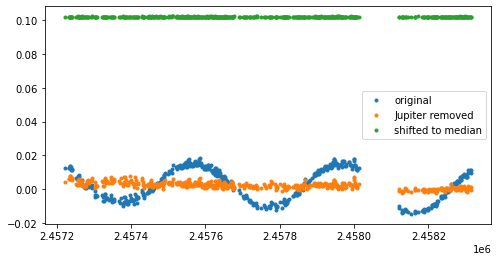

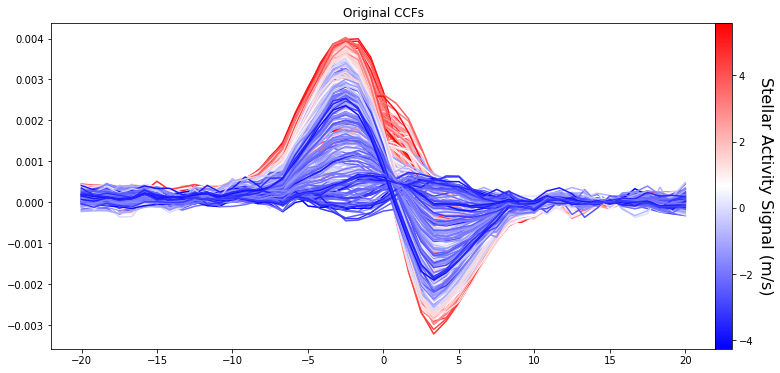

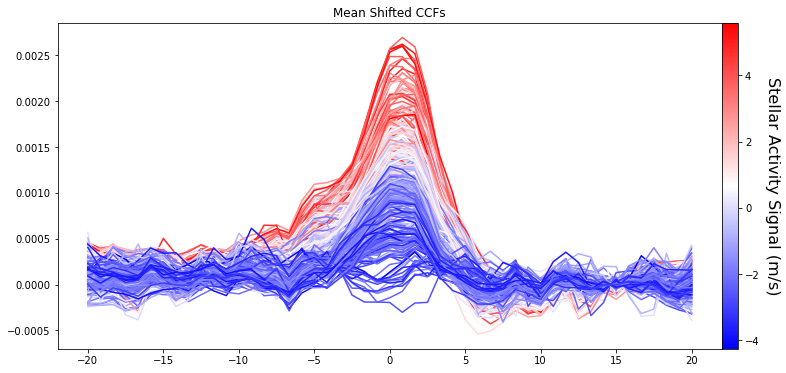

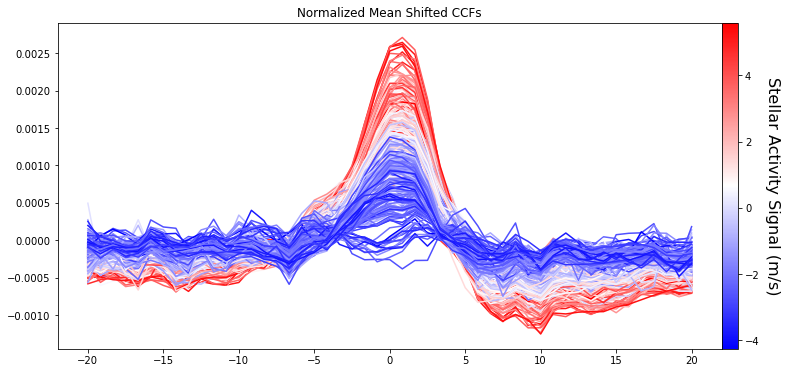

In [34]:
# No planet injection, just remove Jupiter and shift the rvs to zero 
# This cell is mainly helpful as a diagnostic, but does not write the shifted ccfs to new files

zero_or_median = "median"
shift_by_rv =  "mpyfit_rvs"#"prov_rvs" #or "mpyfit_rvs"#
index_cut_num = 19.16666667

df_master = master_shifting(bjd, ccfBary, rvh,
                    ref_frame_shift="off", #"off" or a specific value in km/s
                    removed_planet_rvs= -bsrv, #array of rv values for planet signal in km/s
                    zero_or_median = zero_or_median,
                    p_no = [0.6, 0.0, 2.7, 1.0],
                    shift_by_rv = shift_by_rv,
                    fwhm = fwhm,
                    cont = cont, 
                    bis = bis,
                    index_cut_num = index_cut_num)

mu_plotting(df_master,["mu_og_list","mu_jup_list", "mu_zero_list"],
            ["original", "Jupiter removed","shifted to "+str(zero_or_median)])

wls = np.linspace(-20, 20, 49)

residual_plot(df_master["vrad_star"]*1000, wls,df_master["og_ccf_list"], 484, plot_title = "Original CCFs")
#residual_plot(df_master["vrad_star"], df_master["planet_shifted_CCF_data_list"], "median", plot_title = "Injected Planet Shifted CCFs")
residual_plot(df_master["vrad_star"]*1000, wls, df_master["zero_shifted_CCF_list"], 484, plot_title = "Mean Shifted CCFs")
residual_plot(df_master["vrad_star"]*1000, wls, df_master["CCF_normalized_list"], 484, plot_title = "Normalized Mean Shifted CCFs")

# plot results
#residual_plot(df_master["vrad_star"], wls[4:156], df_master["CCF_normalized_list_cutoff"], 544, plot_title = "Normalized Mean Shifted CCFs")


df_master

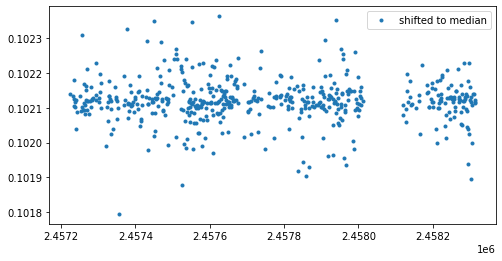

In [35]:
mu_plotting(df_master,["mu_zero_list"],
            ["shifted to "+str(zero_or_median)])
# 50 cm/s

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

plt.plot(df["BJD"], df_master["mu_zero_list"]-, ".", label=names[i])
plt.legend()

## write to a fits file

In [22]:
np.shape([l.tolist() for l in df_master["og_ccf_list"]])

(528, 49)

In [31]:
col2 = fits.Column(name='og_ccf_list', format='528E', dim='(49)',
                       array=np.array([l.tolist() for l in df_master["og_ccf_list"]]))
col2

name = 'og_ccf_list'; format = '528E'; dim = '(49)'

In [18]:
zero_or_median = "median"
shift_by_rv =  "prov_rvs" #"mpyfit_rvs"#or
clipped = "clipped"

shifter_fits_maker(bjd, ccfBary, rvh,
                        ref_frame_shift="off", #"off" or a specific value in km/s
                        removed_planet_rvs= -bsrv, #array of rv values for planet signal in km/s
                        zero_or_median = zero_or_median,
                        shift_by_rv = shift_by_rv,
                        fwhm = fwhm,
                        cont = cont, 
                        bis = bis,
                        index_cut_num = index_cut_num,
                        path = 'shifted_fits_clean_'+zero_or_median+'_'+shift_by_rv+'_'+clipped+'_Oct27_one_file')

VerifyError: The following keyword arguments to Column were invalid:
    The repeat count of the column format 'og_ccf_list' for column '49E' is fewer than the number of elements per the TDIM argument '(528)'.  The invalid TDIMn value will be ignored for the purpose of formatting this column.

In [34]:
np.array([l.tolist() for l in df_master["og_ccf_list"]]).reshape((528 ,49))

array([[1.00150967, 1.00002646, 0.99851841, ..., 1.0014503 , 1.00178933,
        1.00203037],
       [1.0014056 , 0.99990964, 0.99838215, ..., 1.00164509, 1.00206935,
        1.00231409],
       [1.00136328, 0.99992639, 0.9984147 , ..., 1.00153542, 1.00192058,
        1.00214958],
       ...,
       [1.00108349, 0.99965233, 0.99816853, ..., 1.00143445, 1.00178301,
        1.00197899],
       [1.0011425 , 0.99964464, 0.99819916, ..., 1.0013417 , 1.00174582,
        1.00193501],
       [1.00103831, 0.99949563, 0.99807036, ..., 1.00132012, 1.00171173,
        1.0019238 ]])

In [ ]:
# Check file contents

hdul = fits.open('shifted_fits_clean_'+zero_or_median+'_'+shift_by_rv+'_'+clipped+'_Aug24_one_file/shifted_ccfs_combined.fits', memmap=False)

# extracts activity signal and rv_data
ccf_tests = hdul[1].data['CCF_normalized_list_cutoff']
num = 0

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
for i in np.arange(0,629):
    plt.plot(wls[4:156], ccf_tests[i]-ccf_tests[544])
    num += 1

## write to TF records

In [ ]:
# write fits files into TF_Records
# Choose path to pull fits files from: 'input_path'
# Choose path to write TF_Records to: 'path;
# Choose number of fits files: 'numfits'
# Choose random seed for shuffling: 'randseed'

pathname= '/Users/Zoe/Documents/SOAP_2/Archive_HARPS_N/TF_record_Aug_24_21_no_planets_'+clipped+'_'+zero_or_median+'_'+shift_by_rv

tf_writer(input_path = 'shifted_fits_clean_'+zero_or_median+'_'+shift_by_rv+'_'+clipped+'_Aug24_one_file/',
          path=pathname+'/',
          numfits=629, randseed =42)#37)

## older code (pre-October 2021)

49

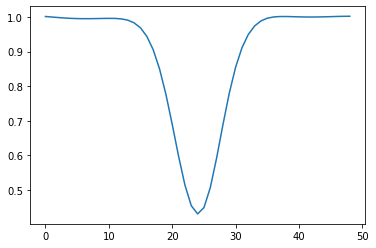

In [111]:
#np.average(DRS_new_vrad_list, weights=DRS_weight_new_sig_vrad_list)
#len(mean_ccf)
plt.plot(normalized_ccf)
len(hdul[1].data[68])

In [105]:
len(np.arange(-20, 20, 0.5))

80

In [46]:
index = new_bjd_list.get_loc(bjd, method = "nearest")
print(bjd)
print(df["quality"][index])

2457376.12272715
0.7459557889241406


In [52]:
print(len(df["quality"]))
len(df["quality"][df["quality"]<0.99])

98019


28923

In [10]:
hdul[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2021-07-23T11:21:54' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
VERSION =               120203 / Application parameter value                    
DWELL   =               300000 / Application parameter value                    
RD_TIME =                    0 / Application parameter value                    
RS_TIME =                  383 / Application parameter value                    
FRM_TYPE=                    1 / Application parameter value                    
NUM_EXPS=                   

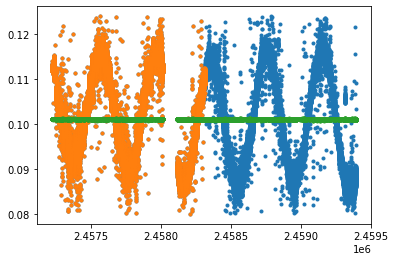

In [22]:
plt.plot(df["bjd"], df["rvraw"], ".")
plt.plot(bjd_list, DRS_new_vrad_list, ".")
plt.plot(df["bjd"], df["rvheli"]*0.01+0.1, ".")

In [6]:
len(DRS_new_vrad_list)

#Save loaded data as NPZ files

outfile = 'HARPS2_3_1.npz'#TemporaryFile()#"test_savez_file"

np.savez(outfile, bjd_list=bjd_list, DRS_new_vrad_list=DRS_new_vrad_list, DRS_new_berv_list=DRS_new_berv_list)

In [7]:
npzfile = np.load(outfile)
npzfile.files

['bjd_list', 'DRS_new_vrad_list', 'DRS_new_berv_list']

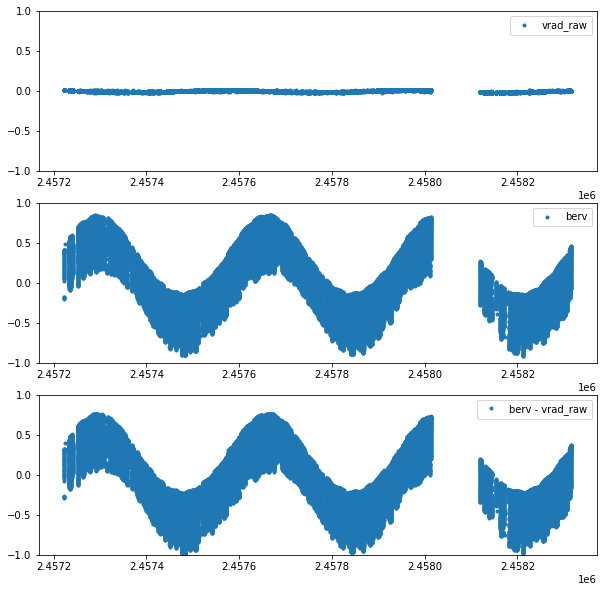

In [8]:
fig, ax = plt.subplots(3,1, figsize=(10, 10))
ax[0].plot(bjd_list,DRS_new_vrad_list-np.mean(DRS_new_vrad_list), ".", label="vrad_raw")
ax[1].plot(bjd_list,DRS_new_berv_list-np.mean(DRS_new_berv_list), ".", label="berv")
ax[2].plot(bjd_list,np.array(DRS_new_berv_list)-DRS_new_vrad_list, ".", label="berv - vrad_raw")



for i in [0,1,2]:
    ax[i].legend(loc="upper right")
    ax[i].set_ylim(-1, 1)
    

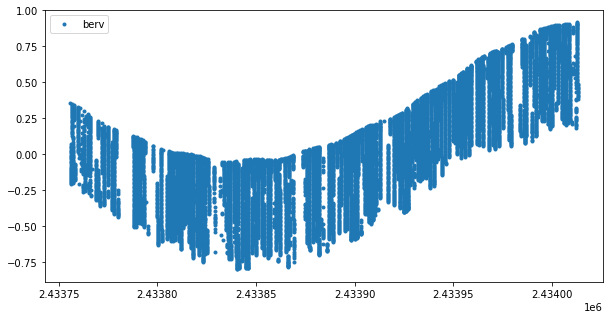

In [32]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
plt.plot(np.array(bjd_list)-24000,DRS_new_berv_list-np.mean(DRS_new_berv_list), ".", label="berv")
ax.legend()

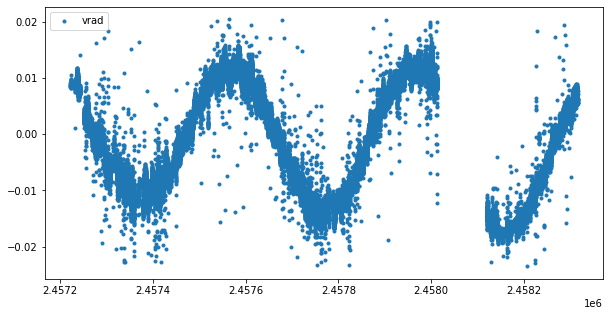

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
plt.plot(bjd_list,DRS_new_vrad_list-np.mean(DRS_new_vrad_list), ".", label="vrad")
ax.legend()



In [123]:
np.max(bjd_list)-np.min(bjd_list)

780.6867202799767

In [80]:
missing_dates = []
full_bjd_list = []
qflag_bjd_list_diff = []
removed_counter = 0
qflag_removed_counter = 0
ccf_counter = 0
gen_counter = 0
#fig, ax = plt.subplots(figsize=(10, 7))
#fig3, ax3 = plt.subplots(figsize=(10, 7))

for directory in directories:
    #print(directory)
    if directory == '.DS_Store':
        continue
    files = os.listdir(str('hpcstorage'+str(year)+'/buchschn/HARPN/reduced/'+directory))
    
    #fig, ax = plt.subplots(figsize=(10, 7))
    bjd_list =[]
    ccf_list = []
    DRS_qflag_list = []
    DRS_new_fwhm_list = []
    DRS_new_contrast_list = []
    DRS_new_vrad_list = []
    DRS_new_berv_list = []
    DRS_vrad_raw_list = []
    DRS_new_bis_span_list = []
    
    DRS_new_sig_vrad_list = []
    DRS_new_sig_fwhm_list = []
    DRS_new_sig_contrast_list = []
    DRS_new_sig_bis_span_list = []
    
    DRS_weight_new_sig_vrad_list = []
    DRS_weight_new_sig_fwhm_list = []
    DRS_weight_new_sig_contrast_list = []
    DRS_weight_new_sig_bis_span_list = []
    
    rv_axis = np.linspace(-20,20, 161)
    for file in files:
        #print(file)
        ccf_counter += 1
        hdul = fits.open(str('hpcstorage'+str(year)+'/buchschn/HARPN/reduced/'+directory+"/"+file), memmap=False)
        ccf = hdul[1].data[69]
        bjd = hdul[0].header["HIERARCH TNG QC BJD"]
        
        new_bjd_list = pd.Index(df['bjd'])
        i = new_bjd_list.get_loc(bjd, method = "nearest")
        #print(np.abs(df['new_bjd'][i]))
        
        # Check that the BJD is within 10 seconds (0.000115741 days)
        if (np.abs(df['bjd'][i]-bjd)) > 0.000115741:
            #print("the difference in BJD is more than 10 seconds for BJD: "+str(bjd))
            removed_counter +=1
            continue
        
        DRS_new_vrad= hdul[0].header['HIERARCH TNG QC CCF RV'] #df['new_vrad'][i]
        DRS_new_berv= hdul[0].header['HIERARCH TNG QC BERV'] #df['new_berv'][i]
        #DRS_vrad_raw= df['new_vrad_raw'][i]
        DRS_new_sig_vrad = df["HIERARCH TNG QC CCF RV ERROR"][i]
        DRS_weight_new_sig_vrad = 1/(DRS_new_sig_vrad)**2
        DRS_new_fwhm = df["new_fwhm"][i]
        DRS_new_sig_fwhm = df["new_sig_fwhm"][i]
        DRS_weight_new_sig_fwhm = 1/ (DRS_new_sig_fwhm)**2
        DRS_new_contrast = df["new_contrast"][i]
        DRS_new_sig_contrast = df["new_sig_contrast"][i]
        DRS_weight_new_sig_contrast = 1/(DRS_new_sig_contrast)**2
        DRS_new_bis_span = df["new_bis_span"][i]
        DRS_new_sig_bis_span = df["new_sig_bis_span"][i]
        DRS_weight_new_sig_bis_span = 1/(DRS_new_sig_bis_span)**2
        #ax.plot(rv_axis,ccf, color= 'b')
        
        qflag_bjd = bjd- 2400000
        qflag_list = pd.Index(df['BJD'])
        q_index = qflag_list.get_loc(qflag_bjd, method = "nearest")
        qflag_bjd_diff = np.abs(df['BJD'][q_index]-qflag_bjd)
        
        # extract values from DRS and weights
        DRS_qflag = df["quality"][q_index]
        if qflag_bjd_diff > 0.00081 or DRS_qflag <0.99:
            #print("the difference in BJD is more than 10 seconds for BJD: "+str(bjd))
            qflag_removed_counter += 1
            continue
        qflag_bjd_list_diff.append(qflag_bjd_diff)
        ccf_list.append(ccf)
        bjd_list.append(bjd)
        full_bjd_list.append(bjd)
        
        # append values from DRS
        DRS_qflag_list.append(DRS_qflag)
        DRS_new_fwhm_list.append(DRS_new_fwhm)
        DRS_new_contrast_list.append(DRS_new_contrast)
        DRS_new_vrad_list.append(DRS_new_vrad)
        DRS_new_berv_list.append(DRS_new_berv)
        DRS_vrad_raw_list.append(DRS_vrad_raw)
        DRS_new_bis_span_list.append(DRS_new_bis_span)
        
        # append sig from DRS
        DRS_new_sig_vrad_list.append(DRS_new_sig_vrad)
        DRS_new_sig_fwhm_list.append(DRS_new_sig_fwhm)
        DRS_new_sig_contrast_list.append(DRS_new_sig_contrast)
        DRS_new_sig_bis_span_list.append(DRS_new_sig_bis_span)
        
        # append weights from DRS
        DRS_weight_new_sig_vrad_list.append(DRS_weight_new_sig_vrad)
        DRS_weight_new_sig_fwhm_list.append(DRS_weight_new_sig_fwhm)
        DRS_weight_new_sig_contrast_list.append(DRS_weight_new_sig_contrast)
        DRS_weight_new_sig_bis_span_list.append(DRS_weight_new_sig_bis_span)
        
        #print("  - - - ")
    if not ccf_list:
        #print("There are no DRS RVs on "+str(directory))
        print(str(directory))
        missing_dates.append(directory)
        continue
    # take the (weighted) averages for that day of observations
    mean_ccf = np.mean(ccf_list, axis=0)
    median_DRS_qflag = np.mean(DRS_qflag_list)
    median_DRS_new_fwhm = np.average(DRS_new_fwhm_list, weights = DRS_weight_new_sig_fwhm_list)
    median_DRS_new_contrast = np.average(DRS_new_contrast_list, weights = DRS_weight_new_sig_contrast_list)
    median_DRS_new_vrad = np.average(DRS_new_vrad_list, weights=DRS_weight_new_sig_vrad_list)
    median_DRS_new_berv = np.mean(DRS_new_berv_list) #no weights exist
    median_DRS_vrad_raw = np.mean(DRS_vrad_raw_list) #no weights exist
    median_DRS_new_bis_span = np.average(DRS_new_bis_span_list, weights= DRS_weight_new_sig_bis_span_list)
    median_bjd = np.mean(bjd_list)
    #ax.plot(rv_axis,ccf, label = "all ccf's", color= 'b')
    #ax.plot(rv_axis,mean_ccf, label = "mean ccf, "+str(median_bjd), color= 'r')
    #ax.set_xlabel("RV (m/s)", size =15)
    #ax.set_ylabel("CCF", size =15)
    #ax.legend()

    #print(median_bjd)
    #print(median_DRS_new_vrad)
    
    #fig2, ax2 = plt.subplots(figsize=(10, 7))
    x_mean = [median_DRS_new_vrad]*len(DRS_new_vrad_list)
    #ax2.scatter(bjd_list,DRS_new_vrad_list, label = "all rv's", color='b')
    #ax2.plot(bjd_list,x_mean, label = "mean rv", color = 'r')
    #ax2.set_xlabel("BJD", size =15)
    #ax2.set_ylabel("DRS RV", size =15)
    #ax2.legend()
    
    # Normalize the CCF
    rv_data = np.linspace(-20, 20, 161)
    x = np.where(abs(rv_data) > 10)
    non_peak = mean_ccf[x]
    p3guess = np.median(non_peak)
    #p_guess = [-np.min(mean_ccf)+p3guess, 0., 3, p3guess]
    #pfit, results = mpyfit.fit(least, p_guess, (rv_axis, mean_ccf), parinfo)
    #A = pfit[0]
    #C = pfit[3]
    #print(pfit)
    #print(C)
    normalized_ccf =(mean_ccf/p3guess)
    #gauss_guess = -p_guess[0] * np.exp(-(rv_axis - p_guess[1]) ** 2 / (2. * p_guess[2] ** 2)) + p_guess[3]
    #gauss_fit = -pfit[0] * np.exp(-(rv_axis - pfit[1]) ** 2 / (2. * pfit[2] ** 2)) + pfit[3]
    #ax.plot(rv_axis,gauss_fit,label = "gauss fit")
    #ax.plot(rv_axis,gauss_guess,label = "gauss guess")
    #ax.legend()
    #ax3.plot(rv_axis,normalized_ccf)
    
    
    # Write CCF, BJD, and RV to a fits file
    hdu_new = fits.ImageHDU()
    hdr = fits.Header()
    primary_hdu = fits.PrimaryHDU(header=hdr)
    hdul = fits.HDUList([primary_hdu, hdu_new])
    
    #creates columns in CCF.fits files
    #col1 = fits.Column(name='CCF data', format='E', array=normalized_ccf)
    
    hdu = fits.PrimaryHDU(normalized_ccf)
    hdulist = fits.HDUList([hdu])
    
    # Set header
    hdulist[0].header.set("qflag", median_DRS_qflag,'RV [km/s]')
    hdulist[0].header.set("fwhm", median_DRS_new_fwhm,'FWHM [km/s]')
    hdulist[0].header.set("contrast", median_DRS_new_contrast,'contrast')
    hdulist[0].header.set("bis_span", median_DRS_new_bis_span,'bis span [km/s]')
    hdulist[0].header.set('rvh', median_DRS_new_vrad, 'RV [km/s]')
    hdulist[0].header.set('berv', median_DRS_new_berv, 'RV [km/s]')
    hdulist[0].header.set("vradraw", median_DRS_vrad_raw,'RV [km/s]')
    hdulist[0].header.set("BJD", median_bjd, 'Barycentric JD (from DRS)')
                          
    # check whether folder exists. If not, make it
    CCF_folder_outputs = 'fits/fits_'+str(year)
    if not os.path.exists(CCF_folder_outputs):
        os.mkdir(CCF_folder_outputs)
    
    # write and close hdul
    #hdulist.writeto('fits/fits_'+str(year)+'/ccf' +directory+'.fits')
    hdulist.close()
    gen_counter +=1
    if gen_counter%50==0:
        print(gen_counter)
    #print("_______")
    #if directory == "2020-02-06":

FileNotFoundError: [Errno 2] No such file or directory: 'hpcstorage2015/buchschn/HARPN/reduced/2015-12-19'

In [27]:
#2015: 4376 - 91 = 4,285
#2016: 13458 -110 = 13,348
# 2017: 10635 - 2,346 = 8,289
# 2018: 12469 - 2,836 = 9,633


#2015: 91/4376 = 0.02
#2016: 110/13458 = 0.0008
#2017: 2,346/10,635 = 0.220
#2018: 2,836/12469 =0.227
ccf_counter

12469

In [28]:
qflag_removed_counter

2836

In [504]:
rv_data = np.linspace(-20, 20, 161)
x = np.where(abs(rv_data) > 10)

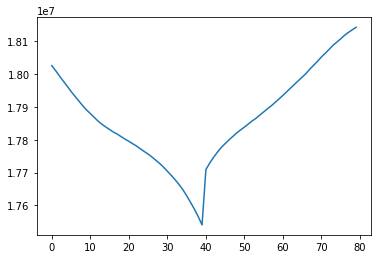

In [506]:
plt.plot(mean_ccf[x])

In [ ]:
2457328.0335699-2400000

In [ ]:
np.mean(qflag_bjd_list_diff)

In [ ]:
np.min(full_bjd_list)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(np.array(full_bjd_list)-2400000, qflag_bjd_list_diff)
ax.set_ylabel("Offset between BJD (Days)", size = 12)
ax.set_xlabel("BJD from TNG Header", size = 12)
ax.set_ylim(0.00076, 0.00082)

In [ ]:
qflag_removed_counter

In [ ]:
ccf_counter

In [ ]:
hdul[0].header["HIERARCH TNG QC CCF RV"]

In [ ]:
hdul[0].header["HIERARCH TNG QC BERV"]

In [ ]:
sorted(missing_dates)
for i in sorted(missing_dates):
    print(i)

In [ ]:
removed_counter

In [ ]:
import julian
import datetime


In [ ]:
files = os.listdir("fits_"+str(year)+"/")

In [ ]:
mu_fits = []
bjd_list = []
berv_list = []
rv_list = []
vradraw_list = []
CCF_data_list = []
files_list = []

In [ ]:
# Check contents to see whether Jupiter is removed or not??
year = "2015"

files = os.listdir("fits/fits_"+str(year)+"/")
for file in sorted(files):
    if file == ".DS_Store":
        continue
    print(file)
    files_list.append(file)
    hdul2 = fits.open(str("fits/fits_"+str(year)+"/"+file), memmap=False)
    bjd_test = hdul2[0].header["BJD"]
    bjd_list.append(bjd_test-2400000)
    rv = hdul2[0].header["rvh"]
    rv_list.append(rv)
    berv = hdul2[0].header["berv"]
    berv_list.append(berv)
    vradraw = hdul2[0].header["vradraw"]
    vradraw_list.append(vradraw)
    CCF_data = hdul2[0].data
    CCF_data_list.append(CCF_data)
    
    # Plot ccf_data
    plt.plot(CCF_data)
    
    #fit ccf_data
    rv_axis = np.linspace(-20, 20, 161)
    p_guess = [1, 0.1, 1., 0.5]
    pfit, results = mpyfit.fit(least, p_guess, (rv_axis, CCF_data), parinfo)
    mu = pfit[1]
    mu_fits.append(mu)
    
    print(bjd_test)
    date= julian.from_jd(bjd_test-2400000, fmt='mjd')
    print(date)
    print("_______")
    

In [ ]:
hdul2[0].header

In [ ]:
(np.max(berv_list)-np.min(berv_list))/(np.max(mu_fits)-np.min(mu_fits))

In [ ]:
# plot mu fits over time to figure out whether jupiter was removed from CCFs

fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(bjd_list, mu_fits)
#ax.set_xlim(2457391.0619573, 2457716.93670025)
ax.set_xlabel("BJD", size= 16)
ax.set_ylabel("mu fit to ccfs", size= 16)

In [ ]:
# plot mu fits over time to figure out whether jupiter was removed from CCFs

fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(bjd_list, berv_list, label="berv from DRS")
#ax.scatter(bjd_list, mu_fits, label = "mu fits")
#ax.set_xlim(2457391.0619573, 2457716.93670025)
ax.set_xlabel("BJD", size= 16)
ax.set_ylabel("berv_list to ccfs", size= 16)
ax.legend()

In [ ]:
# plot v_rad_raw fits over time to figure out whether jupiter was removed from CCFs

fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(bjd_list, vradraw_list, label="vradraw from DRS")
ax.scatter(bjd_list, mu_fits, label="mu fits")
#ax.scatter(bjd_list, mu_fits, label = "mu fits")
#ax.set_xlim(2457391.0619573, 2457716.93670025)
ax.set_xlabel("BJD", size= 16)
ax.set_ylabel("berv_list to ccfs", size= 16)
ax.legend()

## Removing jupiter and shifting to zero

In [546]:
coeff_list= []
number_of_iterations_list = []
mu_og_list = []
mu_jup_list = []
mu_zero_list = []
BJD_list = []
shifted_CCF_list = []

mu_fits = []
berv_list = []
rv_list = []
vradraw_list = []
CCF_data_list = []
files_list = []

In [547]:
def gauss(x, p):
    return -p[0] * np.exp(-(x - p[1]) ** 2 / (2. * p[2] ** 2)) + p[3] +p[4]*x +p[5]*x**2

# A simple minimization function:
def least(p, args):
    x, y = args
    return gauss(x, p) - y

In [548]:
# Remove slope problem
full_rv_signal_list = [0.005025528907819565, 0.005375766223380985, 0.006387548542578211, 0.006671668468640418, 0.006865386379104219, 0.007994358603170416, 0.006846942085494957, 0.005343229531182608, 0.005990162731040403, 0.00553331382426789, 0.002734499764787659, 0.004078345308894864, 0.003631054875354992, 0.003501994358723631, 0.003660581983920363, 0.001795549631786095, 0.003170395108751025, 0.006030003752944206, 0.005899435534949315, 0.006181715291961614, 0.004971454623267916, 0.003271641419277709, 0.003218255887953562, 0.003316392161752384, 0.004294368314400623, 0.003547483009405256, 0.004596945801075491, 0.002609854750946653, 0.00333234361730312, 0.002073699856228968, 0.001216714131445829, 0.001444967414471507, 0.001873705153182967, 0.002530340575794132, 0.003992181980091694, 0.003722372378248257, 0.003468511539533367, 0.001997021848707081, 0.002104065775980367, 0.002529125199840319, 0.004350667161354673, 0.004288654920164454, 0.00530923733601167, 0.003229014108345188, 0.003215277973566414, 0.007217797311266675, 0.006796845496382033, 0.003367815813416161, 0.005758558154733543, 0.001283039847059652, 0.001681521890639431, 0.001922308353798556, 0.000641330067744873, 0.001580117656003966, 0.002870594201418715, 0.000634558101573074, 0.004516454276422164, 0.00334007663592304, 0.001129561322417143, 0.001119257676479077, 0.005068093551040793, 0.004557556784366743, 0.005615562181978842, 0.004318743820465949, 0.003739389411306286, 0.003739396459069639, 0.003089462236736449, 0.003584597547655834, 0.003542479805434527, 0.006210905156600428, 0.005263417149792684, 0.004270567718465117, 0.005450241291209155, 0.003933777087906236, 0.004839193291936234, 0.003444182083564722, 0.002708014540559812, 0.005306357057015697, 0.005046927469492993, 0.006098377455695168, 0.004040166590132847, 0.002023036728147032, 0.002097368643048169, 0.00425889961088158, 0.006833389878809214, 0.007200192486998343, 0.004783839990628442, 0.002164110797834881, 0.001428648186674277, 0.002041965289460958, 0.0028760280554981, 0.00636789979864635, 0.003262487533513946, 0.003212522661530129, 0.003760849781286841, 0.005732978000214141, 0.006427443720912173, 0.00403203307515457, 0.001590741577415399, 0.002465418124008632, 0.001577244874384643, 0.001275659553248302, 0.006239789178785587, 0.005259921159045828, 0.002826608607504786, 0.005696960921250114, 0.001761395067183592, 0.003951387696917262, 0.003060576111402177, 0.005095422127273715, 0.005258483538642174, 0.003827669245837367, 0.00144824422945782, 0.000722663352691706, 0.001285302716244857, 0.001382818621886939, -0.0006192152028054, 0.001310904863627639, 0.001929988471046731, 0.002865603294146583, 0.003597704242805777, 0.001830684254135461, 0.002676597169841229, 0.004051292901518101, 0.003641558370666944, 0.003998442665148084, 0.004605507264312066, 0.002405070114852098, 0.00187091792613395, 0.001135091314907442, 0.001403413781847267, 0.001898485552449849, 0.002548171247301224, 0.002182243904998493, 0.002513440086502806, 0.002879307422324175, 0.003768406422186605, 0.001090791598293087, 0.002958127630663885, 0.003302780332870574, 0.00162544664118289, 0.000602104414022882, 0.000652531948601454, 0.000176226825935559, 0.003724730087132335, 0.003239643774983626, -0.00098775708008335, 0.000675686087433438, 0.000685837770946082, 0.000843587862836127, 0.004749015771279358, 0.001889857211499826, 0.00402727920159542, 0.003386930434791735, 0.004809512337845819, 0.002329888816791431, 0.003047391591614611, 0.003975818693501268, 0.003569327760831055, 0.001769069210542956, 0.002932865035414385, 0.003342291527887508, 0.002509463007631358, 0.002050376939838568, 0.005293575849545321, 0.004114270368816902, 0.006156990334520836, 0.004331460674475513, 0.00380424826958158, 0.001510718415005264, 0.001207992664182761, 0.0020156933702006, 0.00352020319535072, 0.003018197352538248, 0.002596736599744755, 0.00340858501483995, 0.003752279372666393, 0.002761551857065351, 0.003173713696854976, 0.00247347436552888, 0.002009481431444793, 0.002806359061793622, 0.001141448677122483, 0.002826874317624788, 0.002605069718532492, 0.001681243599012459, 0.002078641320893708, 0.002128024106320657, 0.001479848753998127, 0.002897189953340226, 0.002889624763196105, 0.002874782851759004, 0.002228991329298149, 0.00444044395029324, 0.002998147788614412, 0.00193573497726976, 0.000902484765362992, 0.002189234013503767, 0.001611081103812672, 0.004046880638333257, 0.002456097458608341, 0.004064632602058072, 0.001619404391660668, 0.002984564717199431, 0.002919973070078419, 0.001147582272802775, 0.001411622582916071, 0.001443580886518023, 0.001044174562713005, 0.001157488348496878, 0.001173157873455915, 0.001000227851335688, 0.001488579933519044, 0.001100116963717108, 0.003328480313225864, 0.003988329226844413, 0.004268478091264486, 0.00617548745309047, 0.003146584439012874, 0.00369114169364477, 0.003036769945660243, 0.001474752447426713, 0.00143462585008258, 0.000312431786975463, 0.000619190610832719, 0.000626440855950999, 0.000741182778086066, 0.000994730625037256, 0.00102451149220002, 0.001444595191169325, 0.001259794322656425, 0.003294984089103589, 0.000460438025089529, 0.001515532404315877, 0.001652786163795699, 0.002172046467998195, 0.000553168039317424, 0.001812668751082713, 0.001290433075183733, 0.00273989628349456, 0.003539918649358105, 0.002979868964846882, 0.003685594119248358, 0.001386359681049092, 0.001063767763605401, 0.001514660319984763, -7.2583013519207e-05, 0.000485834568141037, -0.00026426255326703, 0.000208300773437412, 0.001252790850983764, 0.000381134641230136, 0.001865774999838168, 0.003966507367336399, 0.002020541128792901, 0.002337251713011673, 0.001529473083351829, 0.000650937031058235, 0.000666127189874921, 0.001809951043375553, 0.004359136627049887, 0.003870122871385256, 0.003881373998512733, 0.003802342112737693, 0.002381285191804539, 0.00153665922105029, 0.001102198188321452, 0.001345690933459456, 0.001771448699513496, 5.57286899611744e-05, 0.001236399099962682, -0.00079211552592448, 0.000313013449079041, 6.95615723256229e-05, -0.0002295270435408, 0.001975524860500251, 0.003356054858661456, 0.001674688689049786, 0.003036633990206845, 0.001998840767923854, 0.002325730550166258, 0.001496918901463501, 0.001514492473100871, 0.001639914265200692, -0.00094754415294027, 0.002187230237194067, 0.00121562773128522, 0.001191428655260983, 0.001688817405376605, 0.000916208741762092, 0.001961668505520085, 0.000853151497605588, 0.003979349582556446, 0.00248380568023459, 0.003810716285784136, 0.002539775560237809, 0.001388679918072368, 0.000612037308232885, 0.000947367330190642, -0.00028494478885945, 0.002734822751975866, 0.003563494419513373, 0.001610142711293536, 0.000453013643080528, 0.002282892430775318, 0.000969931164859634, 0.001566777167503679, -0.00039291448772805, 0.003216276023452899, 0.003388730929002513, 0.001219447652601487, 0.001057931164673165, 0.0037516356618578, 0.001175895214006957, 0.001686365980359846, -0.00112900922713123, 0.003488346048060345, -0.00119820061629591, 0.00034154497070253, 0.00104682420200336, 0.003158097059596847, 0.000341300944280759, 0.002445616471753966, 0.002351151097830993, 0.002148259705504566, 0.003304874402075373, 0.000468016389277768, 0.003043648175658104, 0.000861913505972173, -0.00060294053095584, -0.00064960964406859, -0.00018602446435783, -4.1553060061674e-05, 0.00057053188681197, 0.001541949014764569, 0.000794375478685564, 0.000478690569546236, 0.001111671890605267, -0.00039991089655407, 0.001370955898441372, 0.00217367226973255, 0.000844283144467787, 0.001027146807167767, 0.00179595790556392, 0.000351063514645511, -0.00019284642684247, 0.001997113794096588, -0.00023694626813685, 0.000942047393728841, -9.1139097205148e-05, -0.00105491436679518, 0.000590795065592538, 0.000222516604098912, 0.001668181989050442, -0.0008261527035408, 0.00206337007683389, 0.00147191132885575, 0.001853652627473796, 0.001890506757117215, 0.001461827819735476, 0.001419642086646167, 0.000669186167164412, 0.000281927024645868, 0.000632288441917932, 0.000880056310874259, 0.000944105273578586, -0.0007814449350544, -0.00060721737041335, 0.000948623970731814, 0.001540998605360148, 0.001135324958019251, -0.00017732933780754, -0.00105498274718021, 0.002350227582531261, 0.001923429932645779, 0.002047017450365177, 0.001143390451076307, -0.00060490956115112, 0.000610224341093468, 0.000518174972237379, -2.2474466033828e-05, 0.001972134659893066, 0.002219326146000324, 0.002950721291236898, 0.004213686159441282, 0.00103644646669555, 0.001911163408744589, 0.001945425915454318, 0.002437361924936463, 0.001152772678708583, 0.002649620236220533, 0.001646307067945322, 0.000652232421973534, 0.000871708359588397, 0.000394985754460509, -0.00016444339975558, 0.002235165468062919, 0.004230586865285133, 0.003390790949572006, 0.003008119281241608, 0.002466432659802535, 0.002568443737941606, 0.001756846444353191, 0.001870240852802279, 0.002517756874260404, 0.0008997569151253, 0.000603461252856694, 0.002585589693427102, 0.001042993874955166, 0.001915016876137282, 0.001730783990438247, 0.001292221850652285, 0.001808152715895891, 0.00247874875669946, 0.002532292864190054, 0.001158112468714859, 0.001283851682504233, 0.001405214599985365, 0.001231558200899085, 0.001041571322707549, 0.001936791355135523, 0.003687512202802782, 0.002998814668847178, 0.00334773263565785, 0.001802720909243289, 0.002415568187865184, 0.001950902421515601, 0.000682017541859363, 0.001312787706195644, 0.00133101563048652, 0.0013056643959651, 0.001342074442597786, -0.0005637998923718, 0.001116669257687462, 0.002156083163644965, 0.000846068998373376, 0.001156379175764343, 0.001270810797488953, 0.000958155445420314, 0.001112837414488082, 0.001037474214550959, 0.002356887837641817, 0.003690172752807855, 0.004936988692485079, 0.004400291488329836, 0.003434288346881938, 0.001400632138494524, 0.001312005913746436, 0.001102680917182286, 0.000825897505239412, 0.000568947205398492, 0.001191587413217174, 0.000580831117977804, -0.00086503589843311, 0.000292540210635316, 0.001157508966152201, 0.000138809836280865, 0.001026762963415975, -0.00031865552896034, -0.00011041400001639, -3.1380579603209e-05, -0.00023675386633079, 0.001526166708891898, 0.003212664037855213, 0.002022851203912398, 0.004136630021484479, 0.003307008328600737, 0.001238312534935602, 0.001493490030507862, 0.000478684214131892, 9.34568117832442e-05, -0.00147893418678993, 0.000374030422188447, 0.001765179131994522, 0.0019416517923287, 0.002168496618001225, 0.001630226647970766, 0.001472888886961956, 0.001883677614243778, 0.00043840070757396, 0.001561938922220678, 0.001470606482160433, 0.000887787653553423, -1.6270975899024e-05, 0.000123437135026351, 0.002428534599455908, 0.004042804854885781, 0.005055446625838627, 0.005363593438680318, 0.004394772702758207, 0.002457868691589503, 0.00240994007734881, 0.000132878816001725, 0.000299884705311344, -0.00056748008730151, -1.0282969422085e-05, 0.001106941370452209, 0.001440407854539343, 0.000547522219830406, 0.000505432438194823, -0.0002434495010257, -0.00035280425053108, 0.002184051045201519, -0.00130757431860718, 0.00193366398045609, 0.002300435759772036, 0.00570952334306682, 0.004299425368577327, 0.003377525250257285, 0.002712514377112655, 0.00240741269914151, 0.000837296768007052, 0.000450493625188721, -0.00055572667271683, 0.000700179843714106, 0.000548693992128251, 0.00057436662784439, 0.000605578450291393, 0.000736569018483582, 0.000699655319489639, 0.000166514627980024, -0.00032873127223513, -0.00117996930061977, -0.00012339874491832, 0.001463785486560628, 8.84497930964022e-05, 8.72366622090977e-06, 0.000357821540492264, 0.000562602094080714, -0.00113095375383569, -7.4700117280221e-05, -0.00132922169847405, -0.00141964584833334, -0.00106557489268433, -6.2075896536945e-05, -0.00074863152741782, 7.17740061654977e-06, -0.00075146220271145, -0.00175960622229318, -0.00032566450717704, -0.00092706548121153, 9.62992231922258e-05, -0.00102956936691151, -0.00119808407914141, -0.00224162836789198, -0.00239166123967706, -0.00061874372340238, -0.00173674897184011, -0.00078641014330792, -0.00143461921635596, -0.00123269472989538, -0.00134736605075234, -0.00211869300372843, -0.00100005426637048, -0.00075321317887046, -0.00191554406293795, -0.00053203733872125, -0.0005461468543743, -0.00058455982454363, -0.00165642430415504, -0.0009073350291902, -0.00085252093211672, -0.00185029947538452, -0.00166765996568283, -0.00216408554816181, -0.00197569173145251, -0.00217473709500718, -0.00075344662669025, -0.00161342070880812, -0.00122020814762429, -0.00084297667057825, -0.00062450449824523, 0.001263093982319585, 0.001406788401520051, 0.000319943532256964, -0.00122868767193252, -0.00064972932123781, -0.00033980774813269, -0.00141731252693593, -0.00062480692728398, -0.00078718069086754, -0.00115818182240215, -0.00134400712961179, -0.00153557792459196, -0.00087496841539375, -0.00013632517694183, -0.00023176287464978, -0.00025361274498257, -0.00044709033549818, -8.5419448636995e-05, -0.0007489695249837, -0.00035277391540309, -0.00072465014399524, -0.00085035858364262, -0.00084014472518003, -0.00164490153820085, -0.00138571102306107, -9.0246052591636e-05, 0.001131766201634527, 0.000904150409988732, 0.000138299761190407, -0.00016832242665648, -0.00028512747859937, -0.00057035223446804, -0.00071475811291448, -0.0009048667783144, -0.00049085021957052, -0.00018815472373813, 0.000412933463047222, -0.00050451936759374, -0.00027949214986484, -0.0010299461494331, -0.00119725953039295, -3.5831682044535e-05, 0.000115158241199763, 0.000316230764692006, -0.00123928848897028, 6.81230259338729e-05, -0.00173112417673287, -0.00088495242650058, -2.993055172587e-05, -0.00035975421109367, -0.00068860889520255, -0.0008168067119352, -0.0009472807721934, -4.9792324321314e-05, -0.00024974941236878, -0.00090526528300875, -0.00120774697810979, -0.00083031563530324, -0.00111973533957252, -0.00154926475997868, -0.00276061763553424, -0.00261548454132223, -0.00301605243223596, -0.00089315427416086, -1.5409126694699e-05, -2.0109379319312e-05, -0.00195711982608174, -0.00134937643105989, -0.00179067617323168, -0.00093432703363114, 0.000115268919929129, -0.00202211772856711, -0.00179440933808106, -0.00111463288936882, -0.00138535945877786, -0.00124393286285016, -0.00169739058116804, -0.00098646370505051, -0.00244499283850139, -0.00289551179277057, -0.00194044150805009, -0.00152568759706613, -0.00032573715005635, 0.000612882958598857, -0.00174620910888578, -0.00340097410784161, -0.00167498217641719, -0.00083679507049073, -0.00106640003431086, -0.0012913239847547, -0.0008785461112689, -9.7373838472296e-05, -0.00137692360922581, -0.00051195476331928, -0.00131280757187068, -0.00174913613747999, -0.00021178711947854, -0.00190125350228518, -0.00120360689266719, -0.00143319816338106, -0.00165598548849719, -0.00127403661034475, -0.00193452117658147, -0.00213798749038867, -0.00126072210370467, -0.00176719665592906, -0.00262156892491711, -0.00157185409782716, -0.00222496563490416, -0.00234759331019267, -0.00259493643046993, -0.00262434843960752, -0.00276375222443882, -0.00211738759576422, -0.00100730949404832, -0.0022834900290987, -0.00129704556176233, -0.00119987319854397, -0.00093817941478298, -0.00017605620913064, -0.00114657735795642, -0.00186093859651277, -0.00206915092416508, -0.00213427462948043, -0.00242519518096328, -0.00059367913679925, -0.00312577485508073, -0.00310280460264614, -0.00347705656416417, -0.00111877513379637, -0.00227977733633843, -0.00165345623360118, -0.00196364480395352, -0.00426506624188896, -0.00300009430103011, -0.00156263151307815, -0.00024947062251976, -0.0001500332541583, -0.00163731543818461, -0.00261232120897236, -0.00248979798382025, -0.00190211490135687, -0.00158344091751666, -0.00183790040052163, -0.00181017149931797, -0.00176289071097664, -0.00251947684058823, -0.00243351579580863, -0.00190981800806741, -0.00188279784265051, -0.00027792050360842, -0.00135459683781115, -0.000432479618217, 0.00039417741295424, -0.00286576682797537, -0.00397807538753944, -0.0030291417116872, -0.00272248730722223, -0.00265920005512368, -0.00263313755325666, -0.00282822296657371, -0.00030604643966623, -0.00105851964691499, -0.00173381232534779, -0.00225762195734109, -0.00293622978681429, -0.00348328999696369, -0.00675672505154642, -0.00352109387807705, -0.00294592046321415, -0.00268497250560677, -0.00460194886757252, -0.00191646855282248, -0.00212334168800849, -0.00147748078342421, -0.00203605377789149, -0.0037995028261559, -0.00342906321837416, -0.00292231382625264, -0.00062064918454369, -0.00165507971686536, -0.00424145944178635, -0.00299682469095856, -0.00094528666027819, -0.0054753507481071, -0.00251708006705308, -0.00404191746636123, -0.00270493791663252, -0.00303559117658827, -0.00500581841468463, -0.0013518497933144, -0.00252187875907315, -0.0021293314645843, -0.0017086945081157, -0.00345842692034597, -0.00279452828756797, -0.00242814526082804, -0.00231949781208373, -0.00345786985610281, -0.00283360257759106, -0.00217972328632537, -0.00224054349984609, -0.00139908235150273, -0.00189448744916191, -0.00136398598380229, -0.00041396125955035, -0.00151132053603594, -0.0005547097424844, -0.00152824086567987, -0.00126986153673128, -0.00138445556926256, -0.00131579899101238, -0.00264815068308854, -0.00243941490644845, -0.00247847436310526, -0.00373596383022027, -0.00192992352213804, -0.00153446407034948, -0.00150752968760018, -0.0032054091974283, -0.00218783140559535, -0.00227535965654953, -0.00257905749154404, -0.0034856257389662, -0.0031362075208396, -0.00232992983425138, -0.00216092538715994, -0.00099105999828744, -0.00054358780869931, 0.000775605989513444, -1.0231913802855e-05, -0.00304755640933892, -0.00234092011554705, -0.00182503844287341, -0.00232555605602397, -0.00245289009738589, -0.00205547265150764, -0.0016488356652443, -0.00168181005844992, -0.00240476136153233, -0.00071627261021119, -0.00152565395666948, -0.00133708557609528, -0.00072865449425946, -0.00332378363356942, 0.000255021502528741, 0.000176453610912911, -0.00062333342855192, -0.00015410917169618, 0.001737153369914172, 9.55028651576551e-05, -0.00040031405434206, -0.0003440472129014, -0.00055036213272318, -0.0003136858627269, -0.00244888307089659, -0.0019164024469102, -0.00057201202951871, -0.00059307809979492, -0.00306535771480613, -0.00231533355770965, -0.00175163166426736, -0.00034485466775355, -9.5719151215083e-05, 0.000569434537149866, 0.001963968977322041, 0.001332295382656989, 0.001996174924025613, -0.00044574204034024, -0.00035463765369725, -0.00193962180144286, -0.00159309689390206, -0.00087857702033475, -0.00153368185429898, -0.00092181527000443, -0.00099576129354428, -0.00040811824811073, -0.0012770595968128, -0.00141397648717076, -0.00030807852571523, -0.00075356589285581, -0.0003063876016823, -0.00159328559269592, -0.00010091665825968, 4.04339939124276e-05, -0.0007201692985411, -0.00099038560138195, -0.00029152687782304, -0.00050303994458027, 0.001325023648967567, 0.001132533094748016, 0.000315750763322832, 0.001647805888709285, 0.001252438974124264, -0.00036054691366662, -0.0005428757570036, -0.00105268677688203, -0.00029691438893684, -0.00314127837392919, -0.00299971038086746, -0.00190634599797461, -0.0016114864526613, -0.0036210804406549, -0.00197952752515913, -0.00159777381337768, -0.00161739674652749, -0.00373653896991519, -0.00145887757362443, -0.00123184727895997, -0.00230640301906041, -0.00255764662553691, -0.00314484417493828, -0.00281206574464762, -0.00238005486071669, -0.00189698658780819, -0.0005380233682273, -0.00038919773734569, -0.00094730630968429, -0.00106851592011128, -0.00058839473769464, -0.00114099984008976, -0.0016327493661154, -0.00175770185974258, -0.00252540098582291, -0.0020083539901708, -0.00304148756395948, -0.00270018257586059, -0.00184344190187332, -0.00191168076961287, -0.00234673953015318, -0.0021712914084787, -0.0018265164061237, -0.00222272781797449, -0.00146783368483219, -0.00201300357122908, -0.00099246991672545, -0.00248951945417613, -0.00399044291918547, -0.00154986497939774, -0.00138526599754992, -0.00236647223937488, -0.0009856868674067, -0.00195855837031854, -0.00143604086370744, -0.00102192594266265, -0.00157773344108451, -0.00102851042404973, -0.00155822320402961, -0.00238801787402651, -0.0016289963071374, -0.00289549977080201, -0.0031179456040815, -0.00240627125867146, -0.0004540250198588, -0.0005107605320855, 0.000224704602333932, -0.00024677532437525, 0.001179605946214983, 0.002084778994573924, -0.00109945378492271, -0.00028541309034224, -3.1761378992799e-05, -0.00035499381325792, -0.00139607114145904, -0.00149176767392838, -0.00233819950736633, -0.00076264611308542, -0.00074764133095775, -0.00160797544463903, -0.00108721722319095, -0.00085529255215328, -0.00154781380519335, -0.00080127740619389, -0.00013033420708834, -1.6770978929715e-07, -0.00212939317598793, -0.00279754060529542, -0.00240248530004164, -0.00162597103250364, -0.00273279824289309, -0.00181829767045738, -0.00141325329741156, -0.00035548685322197, -1.6295151938399e-06, -0.00108240690902016, -0.00134376054507184, -0.00045920510323543, -0.00069074976815831, -0.00117343128648921, -0.00098619003945068, -0.00083746148416694, -0.00100696148601312, -8.2365131333037e-05, -0.00121891767021402, -0.00096111892117565, -0.00176854139084549, -0.00101107670800952, -0.00042493629433715, -0.00051613530487886, -0.00110425178881352, -0.00186596680765128, -0.00161727842382902, -0.00172613749281814, -0.00139361159993179, -0.00121966142542399, -0.00162783166918411, -0.00119969943842168, -0.00014646220805838, -0.00020038135520037, -0.00054728124594329, -0.00069127221099257, -0.00144698059587082, -0.00138184049266936, -0.00228970786926991, -0.00235214217588153, -0.00067619210173368, -0.00129718066343829, -0.00183960258506464, -0.00184654719543691, -0.00201161680936936, -0.00169395647225053, -0.00113287019553242, -0.00187721182853478, -0.00141104964848248, -0.00155829840523628, -0.00213232740634974, -0.0009915879820895, -0.00170309607452467, -0.00192544174426555, -0.00120212521168562, -0.00021422404392943, -0.00165253570196456, -0.0016266247942568, -0.00164546688100353, -0.00071263699570891, -0.00196833093170738, -0.0012824998365522, -0.00200032802424702, -0.00157804410173339, -0.00133469381987018, -0.00236955860345433, -0.00166610666290756, -0.00118066468056142, -0.00076609262351478, -0.0011455873382051, -0.00104430708863681, -0.00129611967742299, -0.00240949995411272, -0.00208493421613869, -0.00154191519490554, -0.00188851774135872, -0.00122078109185638, -0.00173540998193608, -0.00236137467993835, -0.00157492829797821, -0.00379187557716438, -0.0021071557480376, -0.00172801944291902, 0.001776689835930163, -0.00044241234779332, -0.00159532318552927, -0.00094299112556397, -0.0010304169996685, -0.0009486982027733, -0.00043583592804564, -0.00050111564407399, -0.00068062537603226, -0.00094530285476187, -0.00024561736266973, 0.00020032208464891, 1.04904524605326e-05, -0.00125493027238696, -0.00103076293305791, 0.000105257785592695, -0.00056046883647859, -0.00084910418363725, -0.00054403259579548, -0.00091299449889998, 4.46713194575251e-05, -0.00118974999015736, -0.00018569050176192, -0.00017066617796074, -0.00115690022391535, -0.00164863619051613, -0.00104520569311963, -0.00072640470242324, -0.00169639677322449, -0.00135735195063345, -0.00141427526326043, -0.00172740156877809, -0.00113068649113999, 0.000325100909987466, -0.00076634422593683, -7.2982011908714e-05, -0.00197532401955503, -0.00171077508945677, -0.00086189217637099, -0.00326527367215234, -0.00293351263642334, -0.00205226309477113, -0.0033146179842752, -0.00217002412718818, -0.00218752827502774, -0.00108351545650801, -0.00186564813426744, -0.00120068816222968, -0.00138991184615436]
full_bjd_list = [2457223.914824152, 2457233.004082826, 2457234.126658932, 2457235.108307244, 2457236.069661575, 2457237.106435021, 2457238.003753148, 2457239.216463533, 2457239.945210034, 2457242.019233522, 2457244.974862725, 2457251.85775287, 2457252.117859713, 2457253.16624673, 2457253.957387617, 2457255.164882751, 2457256.003513131, 2457257.062174615, 2457259.42255345, 2457260.147576452, 2457261.082243681, 2457262.079317715, 2457263.10557577, 2457264.086893216, 2457265.025193108, 2457266.020845977, 2457267.090651512, 2457268.072355818, 2457268.989662634, 2457270.044284388, 2457271.037861033, 2457272.863165645, 2457272.93499204, 2457274.049615642, 2457275.106575483, 2457276.860828826, 2457276.888567783, 2457278.003891855, 2457279.244790471, 2457280.10306417, 2457281.049797061, 2457282.006500499, 2457283.059360848, 2457285.86419821, 2457286.022095676, 2457292.86711829, 2457293.020831929, 2457294.02890264, 2457294.897851481, 2457301.865408756, 2457302.01924928, 2457303.021952155, 2457304.063770047, 2457306.015857961, 2457307.001529489, 2457308.040404961, 2457322.019088906, 2457323.991671088, 2457325.014594544, 2457325.989903057, 2457328.007926556, 2457329.00268231, 2457330.025433714, 2457331.023847886, 2457331.930857951, 2457333.04913473, 2457334.021758748, 2457335.018208448, 2457341.030830739, 2457344.980002385, 2457347.034075602, 2457348.032195701, 2457350.036178922, 2457351.020861363, 2457352.995816033, 2457355.014781152, 2457360.917409663, 2457367.995342364, 2457369.086263697, 2457372.015933061, 2457378.069730911, 2457379.02389287, 2457380.040961662, 2457380.994709916, 2457382.064701467, 2457385.070376353, 2457386.044563129, 2457387.032304032, 2457388.012325853, 2457391.0619573, 2457391.91947397, 2457394.040150587, 2457394.925395792, 2457396.114846898, 2457397.0486714, 2457398.045616962, 2457399.020020357, 2457400.04078023, 2457404.107635894, 2457405.965070043, 2457407.051478978, 2457408.05315063, 2457412.14217543, 2457413.024741377, 2457414.062129144, 2457418.082418961, 2457419.043925489, 2457424.111511341, 2457428.106106725, 2457429.046439847, 2457430.118326528, 2457431.028313423, 2457433.070891707, 2457434.057457852, 2457435.051910862, 2457436.043200532, 2457440.123133509, 2457444.0600244, 2457445.035162783, 2457446.01723974, 2457448.030278932, 2457449.03531072, 2457451.013648684, 2457452.00792719, 2457453.045499894, 2457453.974522854, 2457455.029569534, 2457455.910519002, 2457457.071839526, 2457458.002623169, 2457459.023480043, 2457461.993967091, 2457463.045844779, 2457464.945952613, 2457468.068967659, 2457469.191640952, 2457469.972074736, 2457471.070291503, 2457472.037083347, 2457473.868463325, 2457473.975176785, 2457475.021978496, 2457476.208855245, 2457477.042167917, 2457480.092508184, 2457482.179874771, 2457483.85643764, 2457484.319213082, 2457484.987538987, 2457486.129205902, 2457487.10584229, 2457488.080989257, 2457489.080841688, 2457490.057786783, 2457491.01743322, 2457498.243476354, 2457499.043118954, 2457501.856306759, 2457502.091411713, 2457502.99455736, 2457507.155149733, 2457508.20098145, 2457509.115203785, 2457510.02374244, 2457511.860030555, 2457512.124734981, 2457519.925956218, 2457521.851248118, 2457522.100832897, 2457523.02358027, 2457524.055015182, 2457525.147885176, 2457526.123398086, 2457526.986162371, 2457528.371682602, 2457528.99488126, 2457530.854669027, 2457530.963223984, 2457532.22982244, 2457533.169385994, 2457534.120537074, 2457535.004609319, 2457536.027715183, 2457537.46944642, 2457538.08790174, 2457539.065553447, 2457540.017533103, 2457541.65684271, 2457542.117087964, 2457543.017649505, 2457544.16024772, 2457545.030265647, 2457546.052515093, 2457547.064101042, 2457548.087732976, 2457549.061318661, 2457550.011276771, 2457551.184492626, 2457552.064049316, 2457552.963806982, 2457554.163201161, 2457555.071080724, 2457556.083110528, 2457557.084089059, 2457557.970787035, 2457559.974378863, 2457561.034043699, 2457562.006112742, 2457563.057932523, 2457565.067551059, 2457566.865627607, 2457567.090267227, 2457568.064967199, 2457569.148668419, 2457581.8673327, 2457582.159647171, 2457583.014024208, 2457585.028051113, 2457586.175663446, 2457587.358218594, 2457588.117152664, 2457589.014411298, 2457591.038216184, 2457592.052167777, 2457593.971371357, 2457596.132687615, 2457597.532767191, 2457598.14017931, 2457599.10875368, 2457600.00737807, 2457600.975252772, 2457602.022875296, 2457603.112145098, 2457605.040772699, 2457606.85055619, 2457607.318940037, 2457608.853201852, 2457609.028002611, 2457611.860819653, 2457612.041434681, 2457613.85556792, 2457614.089334548, 2457614.911419556, 2457617.099975603, 2457618.069302637, 2457619.08211538, 2457620.065133957, 2457621.004142569, 2457622.853665374, 2457623.07082794, 2457624.037966493, 2457625.077871272, 2457626.024837545, 2457627.091788384, 2457628.032552086, 2457630.084612337, 2457631.120739813, 2457632.042742805, 2457633.137439419, 2457634.069561523, 2457635.858654824, 2457636.079885166, 2457637.097338703, 2457638.087836207, 2457639.084307513, 2457640.055127569, 2457641.225560214, 2457642.080476244, 2457643.087866995, 2457644.079290848, 2457645.113954442, 2457646.098030583, 2457647.077973002, 2457648.055942627, 2457649.041169498, 2457650.058661115, 2457651.04462362, 2457652.055551484, 2457653.072519672, 2457653.993788767, 2457655.046626673, 2457655.999555149, 2457656.994440428, 2457658.024318414, 2457659.017047222, 2457660.865222623, 2457661.041380794, 2457662.095486269, 2457663.067861421, 2457664.063442569, 2457665.096030425, 2457666.000856038, 2457668.102686225, 2457668.911779419, 2457671.077045944, 2457672.046690185, 2457673.034553921, 2457674.045077398, 2457675.02609685, 2457675.986777255, 2457680.912616528, 2457690.988451342, 2457692.038095776, 2457699.890780165, 2457700.912547627, 2457702.020671044, 2457703.033804013, 2457704.024659669, 2457706.002201102, 2457709.035140258, 2457710.031009282, 2457712.029332042, 2457716.93670025, 2457756.138992409, 2457757.043613547, 2457758.0610244, 2457759.965062424, 2457763.092837549, 2457769.113662436, 2457770.048705833, 2457771.998592053, 2457773.036850183, 2457774.973068232, 2457777.066219358, 2457778.047106389, 2457778.952323899, 2457780.170617542, 2457788.06297223, 2457789.039021404, 2457790.050308804, 2457791.045552692, 2457792.08248825, 2457793.048053763, 2457793.939550566, 2457795.183367634, 2457797.965841435, 2457800.12324565, 2457802.040168357, 2457805.080837476, 2457808.036456832, 2457810.02694668, 2457811.033588525, 2457812.037330518, 2457812.998797867, 2457813.994594321, 2457815.002639465, 2457816.046961654, 2457817.032001869, 2457818.028093813, 2457820.042905938, 2457821.036467367, 2457822.020855436, 2457825.022993281, 2457826.000256938, 2457828.949788155, 2457832.86775606, 2457832.87905701, 2457835.86535322, 2457836.042878921, 2457837.015112089, 2457839.866023743, 2457840.059201267, 2457841.030114305, 2457844.86836266, 2457845.045579756, 2457846.07728867, 2457846.896178266, 2457848.094702039, 2457849.079469253, 2457850.081212183, 2457851.049693562, 2457852.116945339, 2457853.009223692, 2457855.859646233, 2457856.092486295, 2457857.023284251, 2457857.896680773, 2457859.859547295, 2457860.007418368, 2457861.186917976, 2457862.120904051, 2457864.858580592, 2457865.020266951, 2457867.084697506, 2457867.963427788, 2457873.843395075, 2457874.189411375, 2457875.263177764, 2457876.043447056, 2457877.032131731, 2457878.855390572, 2457879.026758681, 2457880.64617274, 2457881.020897936, 2457886.85638688, 2457887.029956932, 2457892.184159412, 2457892.980553532, 2457894.850718708, 2457895.113825106, 2457896.019204041, 2457897.8505065, 2457898.132583065, 2457899.14809404, 2457900.07555276, 2457901.15019075, 2457902.123419704, 2457903.101836761, 2457903.941929972, 2457905.153712776, 2457906.051176246, 2457907.087405302, 2457908.088671467, 2457909.034693603, 2457911.056188039, 2457912.86395509, 2457912.999292211, 2457917.116995965, 2457917.903565145, 2457919.865815155, 2457920.050715056, 2457921.012218965, 2457921.988205008, 2457923.062071152, 2457924.010993734, 2457925.131577047, 2457926.053724084, 2457927.055318239, 2457930.863559926, 2457931.002953525, 2457932.012911461, 2457933.036967112, 2457934.027561441, 2457935.047843088, 2457936.016144821, 2457937.007663677, 2457938.193804868, 2457939.006545031, 2457940.084187618, 2457940.990286239, 2457941.991452871, 2457942.967387244, 2457944.035126532, 2457945.014630742, 2457946.00994676, 2457948.011117223, 2457949.861577533, 2457949.990119633, 2457952.21265371, 2457953.102919645, 2457954.073694487, 2457954.992722166, 2457956.128472896, 2457957.033923394, 2457958.09395876, 2457959.031734301, 2457961.857734783, 2457962.103790281, 2457963.106050655, 2457964.097332463, 2457965.091444633, 2457966.93869649, 2457968.136470192, 2457969.097537519, 2457970.08787124, 2457971.073529551, 2457972.007493717, 2457974.852886987, 2457976.859804978, 2457977.489323204, 2457978.047962794, 2457979.141108289, 2457979.88249984, 2457984.237562134, 2457984.922200242, 2457986.033387324, 2457987.048368705, 2457988.963811892, 2457990.852635895, 2457991.038044354, 2457992.06399101, 2457993.855519, 2457993.991502534, 2457995.138874816, 2457996.089994299, 2457997.020589868, 2457999.097486778, 2458000.027490484, 2458001.032253887, 2458002.139860054, 2458003.027254749, 2458003.931915826, 2458005.13599931, 2458006.021446416, 2458007.86179154, 2458008.04200742, 2458012.86299117, 2458013.036681663, 2458015.03799582, 2458016.013413528, 2458017.127404581, 2458018.094522521, 2458018.888139005, 2458021.970343052, 2458023.87087981, 2458023.88406708, 2458026.232075649, 2458027.073517668, 2458028.049232885, 2458028.996019895, 2458030.123438603, 2458031.006973422, 2458032.043942202, 2458033.138402761, 2458034.030620224, 2458034.975439434, 2458036.866116475, 2458037.01346316, 2458038.02653942, 2458042.093183599, 2458044.009650364, 2458046.048938538, 2458046.991379248, 2458051.979104226, 2458057.074490348, 2458058.020859319, 2458060.03554325, 2458061.014250394, 2458068.046340369, 2458163.091263103, 2458164.098657682, 2458165.0162317, 2458171.056022857, 2458171.957622806, 2458178.949632394, 2458182.166240724, 2458183.141296506, 2458186.092113428, 2458188.050145491, 2458188.983109449, 2458190.003522508, 2458190.891934666, 2458191.99015923, 2458193.178202122, 2458195.200754312, 2458195.914458443, 2458197.119112531, 2458198.045113639, 2458198.991162855, 2458200.037994942, 2458201.038045439, 2458202.05253375, 2458207.032986845, 2458208.8681787, 2458208.967255055, 2458211.068847997, 2458212.055875759, 2458213.865250025, 2458214.086328513, 2458215.07941014, 2458216.062165588, 2458217.007420527, 2458218.155522166, 2458219.091812571, 2458220.148476376, 2458221.09600674, 2458222.049383308, 2458223.060208832, 2458224.124555882, 2458225.008293347, 2458226.354512979, 2458227.011191962, 2458233.087231162, 2458234.571514291, 2458235.001859962, 2458236.856564994, 2458237.128328091, 2458238.12641865, 2458239.05072597, 2458241.86576976, 2458242.132379428, 2458242.988040769, 2458245.434936062, 2458245.95425097, 2458247.195547234, 2458247.990163282, 2458248.981998685, 2458251.849954976, 2458252.082575899, 2458253.160711966, 2458254.076734946, 2458255.095150028, 2458256.116719662, 2458257.100508113, 2458258.142445303, 2458259.103730223, 2458260.019073916, 2458266.328050057, 2458267.606199623, 2458268.031181596, 2458270.205847099, 2458271.142642476, 2458272.073494005, 2458273.859051204, 2458274.118059247, 2458275.09387975, 2458276.078143808, 2458277.09422016, 2458278.032504955, 2458279.86067479, 2458280.069896565, 2458281.077655537, 2458282.060782488, 2458283.221232663, 2458284.113545699, 2458285.062061409, 2458286.86443982, 2458287.018661208, 2458287.939782204, 2458289.096021377, 2458290.047783575, 2458291.091780645, 2458292.073146502, 2458293.057254953, 2458294.08062372, 2458295.021593892, 2458296.056800455, 2458297.100417755, 2458298.070543936, 2458299.866193195, 2458300.084449097, 2458301.081401324, 2458302.176802563, 2458303.060228129, 2458303.994721257, 2458305.15906901, 2458306.10359486, 2458307.024205332, 2458308.026332581, 2458311.030446995, 2458312.85521721, 2458313.098016671, 2458314.06608075, 2458315.090301965, 2458316.160661057, 2458317.094965688, 2458318.011032491, 2458319.06980492, 2458320.764204752, 2458321.092034896, 2458322.112686811, 2458323.099830239, 2458324.010309092, 2458325.364243454, 2458326.134996612, 2458327.029614271, 2458329.036535549, 2458330.854673392, 2458331.132331656, 2458332.06761845, 2458333.091987147, 2458333.909382402, 2458336.860561094, 2458337.007370134, 2458338.138060039, 2458339.019946455, 2458340.165782813, 2458341.092040153, 2458341.983160679, 2458345.856563123, 2458346.073102745, 2458347.861314085, 2458348.085733718, 2458349.08663879, 2458350.018959724, 2458351.864278645, 2458351.978668962, 2458353.015913788, 2458354.064941587, 2458355.038977019, 2458356.001275763, 2458358.150848274, 2458359.115456484, 2458360.110814798, 2458361.098954037, 2458362.085483926, 2458363.014514098, 2458364.24501582, 2458365.079817757, 2458366.003661626, 2458367.1802189, 2458368.076891469, 2458369.078939216, 2458370.116055892, 2458371.095477868, 2458372.016039461, 2458373.005006033, 2458378.18876294, 2458379.046013551, 2458380.067736437, 2458381.062875324, 2458382.083553263, 2458383.069401628, 2458384.038404923, 2458385.007246605, 2458386.86729167, 2458386.900104931, 2458389.01296082, 2458390.86448002, 2458391.021900438, 2458393.0293463, 2458394.020884736, 2458394.994460242, 2458399.994615029, 2458402.054086186, 2458403.015955288, 2458404.015470105, 2458405.043245768, 2458407.024732132, 2458407.961900921, 2458410.86845327, 2458410.886162376, 2458411.888011692, 2458417.914336577, 2458420.081516095, 2458421.081795446, 2458423.037341404, 2458424.009906596, 2458425.020855146, 2458426.025283407, 2458427.024842048, 2458427.943030002, 2458429.032169878, 2458430.014200814, 2458431.03700685, 2458431.972173867, 2458433.030728828, 2458434.002520694, 2458435.072444385, 2458436.002838582, 2458437.025604546, 2458438.130846365, 2458442.048947005, 2458442.905631517, 2458446.026675624, 2458449.057439614, 2458451.008325041, 2458452.031293295, 2458453.027731794, 2458454.068656418, 2458455.04088675, 2458456.03641498, 2458458.096901563, 2458460.95913517, 2458464.037327375, 2458465.105775839, 2458466.051469701, 2458467.008588635, 2458468.038909506, 2458469.034680719, 2458470.035190684, 2458471.041360612, 2458475.97441719, 2458478.048635711, 2458479.046451618, 2458480.046529178, 2458481.003234514, 2458484.046883868, 2458485.99334495, 2458488.118069668, 2458494.037396781, 2458495.033753084, 2458496.121151864, 2458497.01607846, 2458498.977735063, 2458502.062909671, 2458502.928013941, 2458504.001179309, 2458505.044627234, 2458506.094551778, 2458507.031207947, 2458508.048469426, 2458509.047548458, 2458510.031426581, 2458511.006204059, 2458512.05951424, 2458515.069601431, 2458516.075194146, 2458517.044995126, 2458518.03660651, 2458519.055057446, 2458520.077317672, 2458520.998436204, 2458522.037288251, 2458523.059685905, 2458524.072095304, 2458525.051426083, 2458528.058590301, 2458529.059475827, 2458532.020020097, 2458533.017102385, 2458534.113616269, 2458534.981113235, 2458537.045869735, 2458540.061828425, 2458541.984673162, 2458544.009821898, 2458545.005583309, 2458546.025111591, 2458547.011512464, 2458548.010537111, 2458549.115418906, 2458550.023397806, 2458551.049870093, 2458551.982785717, 2458552.972381252, 2458554.04249581, 2458555.982681173, 2458557.049313187, 2458557.943147314, 2458559.037310866, 2458561.101817555, 2458562.036220354, 2458563.094691657, 2458563.88663978, 2458565.868281425, 2458566.027740429, 2458569.86295736, 2458569.897217415, 2458578.86659146, 2458579.146988855, 2458580.059364004, 2458581.121472198, 2458581.989143753, 2458583.494307592, 2458583.939725332, 2458585.03533701, 2458586.216082161, 2458587.11260554, 2458588.04077578, 2458589.0766446, 2458589.984219119, 2458591.028473845, 2458592.85868013, 2458593.088080069, 2458594.058438411, 2458595.01051098, 2458596.093197421, 2458597.100973341, 2458597.929003251, 2458599.152482347, 2458599.989522072, 2458601.32218251, 2458602.103632732, 2458602.992847031, 2458604.84407665, 2458605.022899028, 2458606.17134528, 2458606.921534207, 2458608.85559344, 2458609.050791727, 2458611.416054153, 2458612.102853647, 2458613.0915136, 2458614.119395598, 2458615.028749209, 2458616.852122182, 2458617.014306727, 2458618.85041752, 2458618.889581766, 2458621.183743549, 2458622.117976644, 2458623.121346129, 2458623.96870911, 2458625.85084629, 2458626.110091835, 2458627.127780248, 2458627.97292678, 2458629.046675035, 2458630.86607245, 2458631.059381024, 2458632.859313685, 2458633.108667312, 2458634.164976752, 2458635.108878289, 2458636.102644591, 2458637.165561135, 2458638.104903957, 2458639.108769606, 2458640.86831092, 2458640.989762257, 2458642.080728095, 2458643.003254625, 2458645.110641554, 2458646.052433556, 2458647.091326553, 2458648.037741789, 2458649.018179206, 2458650.040904762, 2458651.012690607, 2458652.05497922, 2458653.03581769, 2458654.051138016, 2458655.052315182, 2458656.066949282, 2458657.095795983, 2458658.033696481, 2458659.029948286, 2458660.057068265, 2458661.116500733, 2458662.004075856, 2458663.050084274, 2458663.989998068, 2458665.001308801, 2458668.866057255, 2458669.043554202, 2458670.040868377, 2458671.071818434, 2458672.069280962, 2458673.169769842, 2458674.079710722, 2458675.15846821, 2458676.141095444, 2458677.067253687, 2458678.04532559, 2458679.030495345, 2458680.139741675, 2458681.141232697, 2458682.116613589, 2458683.026068792, 2458684.059830785, 2458686.149591482, 2458687.148030218, 2458688.085548327, 2458689.059722368, 2458691.856060456, 2458692.084953899, 2458693.035575699, 2458694.096170588, 2458695.097762324, 2458696.114489182, 2458697.064944015, 2458698.094202774, 2458699.091542273, 2458700.013781128, 2458701.527620371, 2458701.955315933, 2458703.148263052, 2458704.031913306, 2458705.114662382, 2458705.992747871, 2458707.85697565, 2458708.085914911, 2458708.983278996, 2458710.115684879, 2458711.068030563, 2458713.254912337, 2458714.219533715, 2458715.083288961, 2458717.131191144, 2458718.033289524, 2458719.05179128, 2458721.856228656, 2458722.057197515, 2458722.971319973, 2458724.106704919, 2458725.1978137, 2458726.037650865, 2458727.862970083, 2458728.004198063, 2458729.323540557, 2458730.071570272, 2458730.980118463, 2458732.861259402, 2458733.001401869, 2458734.859870635, 2458735.041754809, 2458736.074666088, 2458737.221422158, 2458738.078820957, 2458739.066884973, 2458740.075029952, 2458741.005100218, 2458745.102706689, 2458746.016199788, 2458747.027281399, 2458748.042807488, 2458748.973119919, 2458750.301597224, 2458751.53472399, 2458751.9154847, 2458753.035893849, 2458754.127467317, 2458754.992528402, 2458774.020253228, 2458776.019918954, 2458777.89021209, 2458786.149450842, 2458786.949177711, 2458788.12268468, 2458791.004065821, 2458792.016051307, 2458794.079184178, 2458795.108603757, 2458796.90232779, 2458799.986313099, 2458804.051673851, 2458804.977959527, 2458806.069692532, 2458810.013585686, 2458811.028962464, 2458812.907094816, 2458814.026337062, 2458817.006008868, 2458818.044341875, 2458819.092609103, 2458820.085841248, 2458821.031662656, 2458821.955683599, 2458826.036000756, 2458827.034609932, 2458827.930004512, 2458829.006506917, 2458830.096077666, 2458832.039141057, 2458832.997853065, 2458835.021725235, 2458836.027283251, 2458837.038885405, 2458839.956491359, 2458841.031208607, 2458842.079317205, 2458844.033417578, 2458845.016525878, 2458846.049298571, 2458849.03819915, 2458852.05028271, 2458853.000119003, 2458856.050388103, 2458858.063685842, 2458859.042076745, 2458860.036344312, 2458861.039622218, 2458862.037661477, 2458863.028734429, 2458864.03788657, 2458865.067677059, 2458866.039140632, 2458867.031165798, 2458868.004415413, 2458868.9926551, 2458876.125040428, 2458877.059174372, 2458879.065305961, 2458881.009520064, 2458882.025402938, 2458883.032856553, 2458885.059607466, 2458885.973983566, 2458887.067304031, 2458889.046255189, 2458891.017499223, 2458893.995377275, 2458895.934610299, 2458896.994485947, 2458898.038098022, 2458900.038301639, 2458900.941622581, 2458902.994616553, 2458905.016169855, 2458906.084612696, 2458907.090125039, 2458907.987638811, 2458909.111013932, 2458910.022439413, 2458913.024305266, 2458914.028625882, 2458915.017704584, 2458915.920470801]
m_slope, b_offset = np. polyfit(bjd_test_list, rv_signal_list, 1) # m = slope, b = intercept.

2457223.914824152
0.005025528907819565
0.9027856865512075

0.9027856865512075

In [197]:
m_slope*(np.array(median_bjd))

-9.133256786816645

In [198]:
 m_slope*(np.array(bjd_test_list))

array([-9.13012031, -9.13015408, -9.13015825, -9.1301619 , -9.13016547,
       -9.13016933, -9.13017266, -9.13017717, -9.13017987, -9.13018758,
       -9.13019856, -9.13022414, -9.1302251 , -9.130229  , -9.13023194,
       -9.13023642, -9.13023954, -9.13024347, -9.13025224, -9.13025494,
       -9.13025841, -9.13026212, -9.13026593, -9.13026958, -9.13027306,
       -9.13027676, -9.13028074, -9.13028438, -9.13028779, -9.13029171,
       -9.1302954 , -9.13030219, -9.13030245, -9.13030659, -9.13031052,
       -9.13031704, -9.13031714, -9.13032129, -9.1303259 , -9.13032909,
       -9.1303326 , -9.13033616, -9.13034007, -9.13035049, -9.13035108,
       -9.13037651, -9.13037708, -9.13038083, -9.13038406, -9.13040995,
       -9.13041052, -9.13041424, -9.13041811, -9.13042537, -9.13042903,
       -9.13043289, -9.13048483, -9.13049216, -9.13049596, -9.13049958,
       -9.13050708, -9.13051078, -9.13051458, -9.13051829, -9.13052166,
       -9.13052581, -9.13052943, -9.13053313, -9.13055547, -9.13

In [551]:
# Shift all files to zero and remove jupiter
year = "2015"

#fig, ax = plt.subplots(figsize=(10, 7))

files = os.listdir("fits/fits_"+str(year)+"/")
for file in sorted(files):
    if file == ".DS_Store":
        continue
    #print(file)
    files_list.append(file)
    hdul2 = fits.open(str("fits/fits_"+str(year)+"/"+file), memmap=False)
    headr = getheader(str("fits/fits_"+str(year)+"/"+file), memmap=False)
    # Extract properties from the header
    median_bjd = hdul2[0].header["BJD"]
    BJD_list.append(median_bjd-2400000)
    
    # Extract properties from observation
    median_DRS_qflag = hdul2[0].header["qflag"]
    median_DRS_new_fwhm = hdul2[0].header["fwhm"]
    median_DRS_new_contrast = hdul2[0].header["contrast"]
    median_DRS_new_bis_span = hdul2[0].header["bis_span"]
    median_DRS_new_berv = hdul2[0].header["berv"]
    
    # extracts the CCF data and rv from fits
    CCF_data = hdul2[0].data
    CCF_data_list.append(CCF_data)
    berv = hdul2[0].header["berv"]
    berv_list.append(berv)
    vradraw = hdul2[0].header["vradraw"]
    vradraw_list.append(vradraw)
    rv = hdul2[0].header["rvh"] -(m_slope*(median_bjd)+b_offset)
    rv_list.append(rv)
    jupiter_shift = vradraw-rv
    #ax.plot(rv_data, CCF_data, label = "original")
    
    # no_shift fit
    rv_data = np.linspace(-20, 20, 161)
    x = np.where(abs(rv_data) > 10)
    non_peak = CCF_data[x]
    median_non_peak= np.median(non_peak)
    
    parinfo = [{'fixed': False, 'step': 1e-3*median_non_peak},
               {'fixed': False, 'step': 1*median_non_peak},
               {'fixed': False, 'step': 1e-3},
               {'fixed': False, 'step': 1e-3*median_non_peak},
               {'fixed': False, 'step': 1e-3*median_non_peak},
               {'fixed': False, 'step': 1e-3*median_non_peak}]
    
    p_no_shifted = [-0.5*median_non_peak, -0.5, 3.5, 1*median_non_peak, 1e-3*median_non_peak, 1e-3*median_non_peak]
    pfit_no_shift, results_no_shift = mpyfit.fit(least, p_no_shifted, (rv_data, CCF_data), parinfo)
    mu_og = pfit_no_shift[1]
    mu_og_list.append(mu_og)
    
    # Jupiter shift
    rv_data = np.linspace(-20, 20, 161)
    rv_data_jupiter_shift = rv_data - jupiter_shift # minus sign
    f_jup = interp1d(rv_data_jupiter_shift, CCF_data, kind='cubic', fill_value='extrapolate')
    jupiter_shifted_CCF_data = f_jup(rv_data)
    #ax.plot(rv_data, jupiter_shifted_CCF_data, label = "jupiter shifted")
    
    # fits the shifted by jupiter data
    p_shifted_jup = [-0.5*median_non_peak, -0.5, 3.5 +jupiter_shift, 1*median_non_peak, 1e-3*median_non_peak, 1e-3*median_non_peak]
    pfit_jup, results_jup = mpyfit.fit(least, p_shifted_jup, (rv_data, jupiter_shifted_CCF_data), parinfo)

    num_iters = results_jup["niter"]
    number_of_iterations_list.append(num_iters)
    coeff_list.append(pfit_jup)
    m = pfit_jup[1]
    mu_jup_list.append(m)
    
    # Shift to zero, after jupiter shift
    shift_to_zero = -rv
    rv_data_shifted = rv_data + shift_to_zero + 0.10001953299548397 - 0.014550377629497218

    f = interp1d(rv_data_shifted, jupiter_shifted_CCF_data, kind='cubic', fill_value='extrapolate')
    shifted_CCF_data = f(rv_data)
    shifted_CCF_list.append(shifted_CCF_data)
    #ax.plot(rv_data, shifted_CCF_data, label = "shifted to zero")
    #ax.set_xlim(-3,3)
    #ax.set_ylim(0.35,0.65)
    #ax.legend()
    
    # fits the shifted data
    p_shifted = [-0.5*median_non_peak, -0.5, 3.5 + shift_to_zero, 1*median_non_peak, 1e-3*median_non_peak, 1e-3*median_non_peak]
    pfit, results = mpyfit.fit(least, p_shifted, (rv_data, shifted_CCF_data), parinfo)
    m_zero = pfit[1]
    mu_zero_list.append(m_zero)#-0.1)

    # finds center of mass
    center_of_mass = np.sum((1-CCF_data)*rv_data)/(np.sum(1-CCF_data))

    #creates columns in CCF.fits files
    col1 = fits.Column(name='RV data', format='E', array=rv_data)
    col2 = fits.Column(name='Shifted CCF data', format='E', array=shifted_CCF_data)
    cols = fits.ColDefs([col1, col2])

    # Combines fits files
    tbhdu = fits.BinTableHDU.from_columns(cols)
    hdu_new = fits.ImageHDU(header=headr)
    hdr = fits.Header()
    primary_hdu = fits.PrimaryHDU(header=hdr)
    hdul = fits.HDUList([primary_hdu, hdu_new])
    hdul.append(tbhdu)
    
    # add new parameters
    hdul[0].header.set('label', rv, 'RV [km/s]')
    #hdul[0].header.set('CENTMASS', center_of_mass, 'center of mass [km/s]')      
    hdul[0].header.set('INSTRMNT', rv, 'HARPS-N')
    hdul[0].header.set("BJD", median_bjd, 'Barycentric JD (from DRS)')
    hdul[0].header.set('MU_og', mu_og, 'km/s')
    hdul[0].header.set('MU_jup', m, 'km/s')
    hdul[0].header.set('MU_zero', m_zero, 'km/s')
    hdul[0].header.set('N_iters', num_iters, 'iterations for fit')
    hdul[0].header.set('Amp', pfit[0], 'coefficient for fit')
    hdul[0].header.set('sigma', pfit[2], 'coefficient for fit')
    hdul[0].header.set('offset', pfit[3], 'coefficient for fit')
                
    #Add old header
    # Set header
    hdul[0].header.set("qflag", median_DRS_qflag,'RV [km/s]')
    hdul[0].header.set("fwhm", median_DRS_new_fwhm,'FWHM [km/s]')
    hdul[0].header.set("contrast", median_DRS_new_contrast,'contrast')
    hdul[0].header.set("bis_span", median_DRS_new_bis_span,'bis span [km/s]')
    hdul[0].header.set('rvh', rv, 'RV [km/s]')
    hdul[0].header.set('berv', median_DRS_new_berv, 'RV [km/s]')
    hdul[0].header.set("vradraw", vradraw,'RV [km/s]')
    hdul[0].header.set("BJD", median_bjd, 'Barycentric JD (from DRS)')
                
    # check whether folder exists. If not, make it
    CCF_folder_outputs = 'shifted_fits_slope/shifted_fits_'+str(year)
    if not os.path.exists(CCF_folder_outputs):
        os.mkdir(CCF_folder_outputs)

    hdul.append(tbhdu)
    print(CCF_folder_outputs +'/'+file+'.fits')

    hdul.writeto(CCF_folder_outputs +'/'+file)
    hdul.close()

shifted_fits_slope/shifted_fits_2015/ccf2015-07-20.fits.fits
shifted_fits_slope/shifted_fits_2015/ccf2015-07-29.fits.fits
shifted_fits_slope/shifted_fits_2015/ccf2015-07-30.fits.fits
shifted_fits_slope/shifted_fits_2015/ccf2015-07-31.fits.fits
shifted_fits_slope/shifted_fits_2015/ccf2015-08-01.fits.fits
shifted_fits_slope/shifted_fits_2015/ccf2015-08-02.fits.fits
shifted_fits_slope/shifted_fits_2015/ccf2015-08-03.fits.fits
shifted_fits_slope/shifted_fits_2015/ccf2015-08-04.fits.fits
shifted_fits_slope/shifted_fits_2015/ccf2015-08-05.fits.fits
shifted_fits_slope/shifted_fits_2015/ccf2015-08-07.fits.fits
shifted_fits_slope/shifted_fits_2015/ccf2015-08-10.fits.fits
shifted_fits_slope/shifted_fits_2015/ccf2015-08-16.fits.fits
shifted_fits_slope/shifted_fits_2015/ccf2015-08-17.fits.fits
shifted_fits_slope/shifted_fits_2015/ccf2015-08-18.fits.fits
shifted_fits_slope/shifted_fits_2015/ccf2015-08-19.fits.fits
shifted_fits_slope/shifted_fits_2015/ccf2015-08-20.fits.fits
shifted_fits_slope/shift

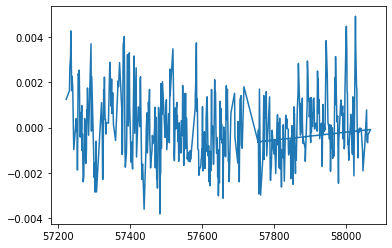

In [205]:
plt.plot(BJD_list,rv_list) #1*m*bjd +b

In [654]:
files = os.listdir("shifted_fits/shifted_fits_2015_16_17_18_half/")
index = np.arange(0, 647, 1)

for i in index:
    print(files[i])

ccf2017-10-31.fits
ccf2016-07-26.fits
ccf2017-06-18.fits
ccf2017-08-06.fits
ccf2016-02-09.fits
ccf2017-08-10.fits
ccf2016-11-19.fits
ccf2016-03-24.fits
ccf2016-01-19.fits
ccf2017-07-23.fits
ccf2016-04-20.fits
ccf2018-06-24.fits
ccf2016-07-30.fits
ccf2015-08-20.fits
ccf2017-06-22.fits
ccf2016-02-25.fits
ccf2018-03-31.fits
ccf2017-09-11.fits
ccf2016-03-08.fits
ccf2018-06-08.fits
ccf2017-01-26.fits
ccf2018-05-18.fits
ccf2016-05-21.fits
ccf2016-09-02.fits
ccf2015-07-29.fits
ccf2017-02-20.fits
ccf2016-06-27.fits
ccf2016-09-14.fits
ccf2017-04-09.fits
ccf2017-09-07.fits
ccf2017-07-19.fits
ccf2017-05-24.fits
ccf2016-05-17.fits
ccf2017-11-10.fits
ccf2018-07-13.fits
ccf2016-08-19.fits
ccf2016-06-07.fits
ccf2018-04-03.fits
ccf2015-09-17.fits
ccf2016-01-03.fits
ccf2017-09-27.fits
ccf2015-12-30.fits
ccf2017-05-04.fits
ccf2017-04-29.fits
ccf2017-06-14.fits
ccf2015-11-20.fits
ccf2016-03-28.fits
ccf2017-05-12.fits
ccf2018-03-11.fits
ccf2016-02-05.fits
ccf2017-06-02.fits
ccf2016-05-01.fits
ccf2016-09-2

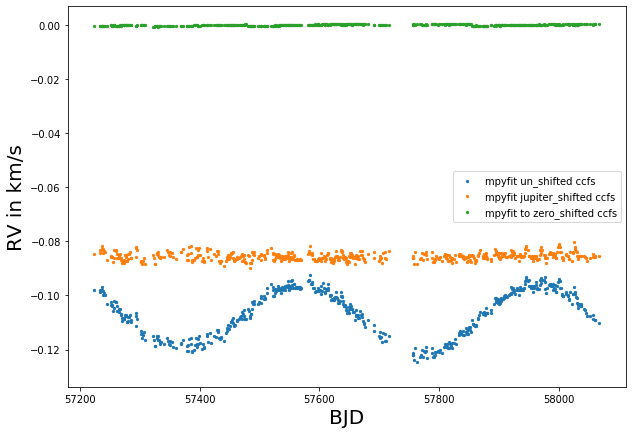

In [206]:
# Plot rv's of all all kinds
fig, ax = plt.subplots(figsize=(10, 7))

#ax.scatter(BJD_list, rv_list, label = "new_vrad", s=5)
#ax.scatter(BJD_list, vradraw_list, label = "vradraw_list", s=5)
ax.scatter(BJD_list, mu_og_list, label = "mpyfit un_shifted ccfs", s=5)
ax.scatter(BJD_list, mu_jup_list, label = "mpyfit jupiter_shifted ccfs", s=5)
ax.scatter(BJD_list, mu_zero_list, label = "mpyfit to zero_shifted ccfs", s=5)
#ax.scatter(BJD_list, vradraw_list-np.array(rv_list), label = "vradraw_list - rv_list", s=5)
ax.set_ylabel('RV in km/s', size=20)
ax.set_xlabel('BJD', size=20)
ax.legend()

In [621]:
np.mean(mu_zero_list)

-0.0003362898953797339

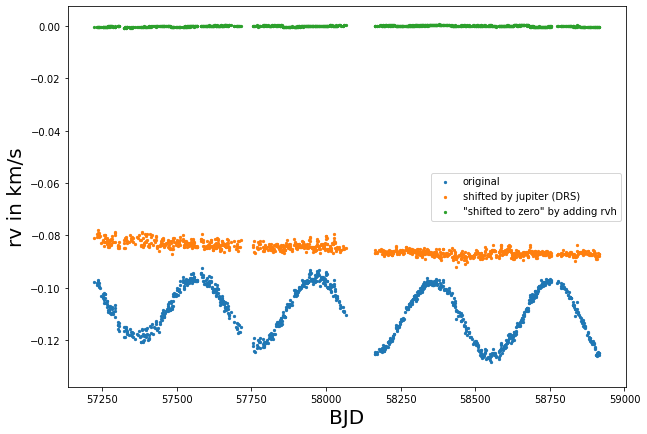

In [628]:
fig, ax = plt.subplots(figsize=(10, 7))


ax.scatter(BJD_list, mu_og_list, label = "original", s=5)
ax.scatter(BJD_list, mu_jup_list, label = "shifted by jupiter (DRS)", s=5)
ax.scatter(BJD_list, mu_zero_list, label = "\"shifted to zero\" by adding rvh", s=5)
ax.set_ylabel('rv in km/s', size=20)
ax.set_xlabel('BJD', size=20)
ax.legend()

In [12]:
CCF_data1_list = []
rv_signal_list = []
bjd_test_list = []
mu_zero_list_after = []

In [13]:
# Open shifted file to check contents
year = "2015_16_17_18"
files = os.listdir("shifted_fits/shifted_fits_"+str(year)+"/")
for file in sorted(files):
    hdul2 = fits.open(str("shifted_fits/shifted_fits_"+str(year)+"/"+file), memmap=False)
    bjd_test = hdul2[0].header["BJD"]
    #print(bjd_test)
    bjd_test_list.append(bjd_test)
    rv_signal = hdul2[0].header["rvh"]
    rv_signal_list.append(rv_signal)
    shifted_CCF_data = hdul2[2].data["Shifted CCF data"]
    CCF_data1_list.append(shifted_CCF_data)
    
    # no_shift fit
    rv_data = np.linspace(-20, 20, 161)
    x = np.where(abs(rv_data) > 10)
    non_peak = shifted_CCF_data[x]
    median_non_peak= np.median(non_peak)
    
    parinfo = [{'fixed': False, 'step': 1e-3*median_non_peak},
               {'fixed': False, 'step': 1*median_non_peak},
               {'fixed': False, 'step': 1e-3},
               {'fixed': False, 'step': 1e-3*median_non_peak},
               {'fixed': False, 'step': 1e-5*median_non_peak},
               {'fixed': False, 'step': 1e-5*median_non_peak}]
    
    # fits the shifted data
    rv_data_shifted = np.linspace(-20, 20, 161)
    #p_shifted = [-0.5*median_non_peak, -0.5, 3.5 + shift_to_zero, 1*median_non_peak, 1e-3*median_non_peak, 1e-3*median_non_peak]
    #pfit, results = mpyfit.fit(least, p_shifted, (rv_data_shifted, shifted_CCF_data), parinfo)
    #m_zero = pfit[1]
    #mu_zero_list_after.append(m_zero)#-0.1)
    
    #hdul1 = fits.open(str("fits/fits_"+str(year)+"/"+file), memmap=False)
    #CCF_data1 = hdul1[0].data
    #CCF_data1_list.append(CCF_data1)

In [14]:
np.max(bjd_test_list)

2458484.046883868

NameError: name 'BJD_list' is not defined

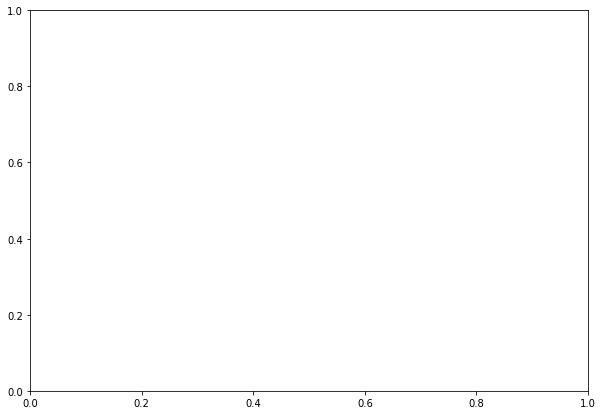

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(np.array(BJD_list), mu_zero_list, label = "mpyfit before writing to file", s=5)
ax.scatter(np.array(bjd_test_list)-2400000, mu_zero_list_after, label = "mpyfit after opening shifted fits file", s=5)
ax.set_ylabel('rv in km/s', size=20)
ax.set_xlabel('BJD', size=20)
ax.legend()

TypeError: unsupported operand type(s) for *: 'module' and 'int'

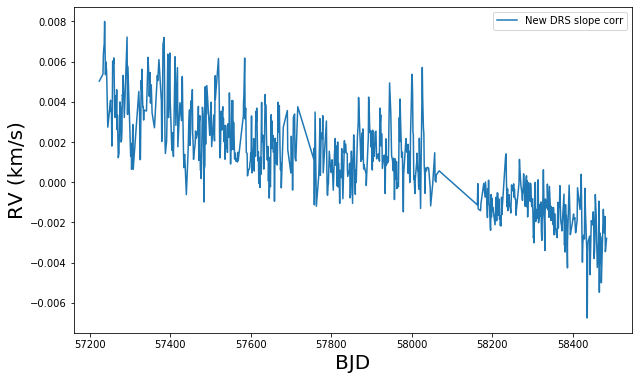

In [15]:
#plt.plot(np.array(bjd_test_list)-2400000, rv_signal_list)
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(np.array(bjd_test_list)-2400000, rv_signal_list, label = "New DRS slope corr")
#ax.plot(bjd_test_list, m*(np.array(bjd_test_list)) + b)
#ax.plot(bjd_test_list[0:540], m_half*(np.array(bjd_test_list[0:540])) + b_half)
ax.set_xlabel("BJD", size = 20)
ax.set_ylabel("RV (km/s)", size = 20)
ax.legend()

print("slope: "+str(m*1000)+ " km/s")

In [17]:
print(rv_signal_list)

[0.005025528907819565, 0.005375766223380985, 0.006387548542578211, 0.006671668468640418, 0.006865386379104219, 0.007994358603170416, 0.006846942085494957, 0.005343229531182608, 0.005990162731040403, 0.00553331382426789, 0.002734499764787659, 0.004078345308894864, 0.003631054875354992, 0.003501994358723631, 0.003660581983920363, 0.001795549631786095, 0.003170395108751025, 0.006030003752944206, 0.005899435534949315, 0.006181715291961614, 0.004971454623267916, 0.003271641419277709, 0.003218255887953562, 0.003316392161752384, 0.004294368314400623, 0.003547483009405256, 0.004596945801075491, 0.002609854750946653, 0.00333234361730312, 0.002073699856228968, 0.001216714131445829, 0.001444967414471507, 0.001873705153182967, 0.002530340575794132, 0.003992181980091694, 0.003722372378248257, 0.003468511539533367, 0.001997021848707081, 0.002104065775980367, 0.002529125199840319, 0.004350667161354673, 0.004288654920164454, 0.00530923733601167, 0.003229014108345188, 0.003215277973566414, 0.0072177973

-0.0037156240651736463


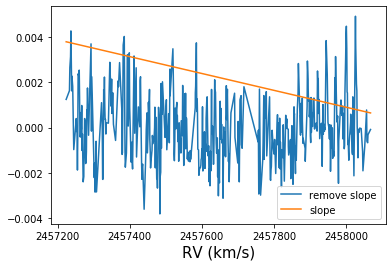

In [188]:
m, b = np. polyfit(bjd_test_list, rv_signal_list, 1) # m = slope, b = intercept.
m_half, b_half = np. polyfit(bjd_test_list[0:540], rv_signal_list[0:540], 1) # m = slope, b = intercept.

slope_sub = m*(np.array(bjd_test_list))+ b

#plt.plot(np.array(bjd_test_list)-2400000, rv_signal_list)
#plt.plot(np.array(bjd_test_list), rv_signal_list)
#plt.plot(bjd_test_list, m*(np.array(bjd_test_list)) + b)
#plt.plot(np.array(bjd_test_list), rv_signal_list, color="g", label="original")
plt.plot(np.array(bjd_test_list), rv_signal_list -1*slope_sub, label="remove slope")
plt.plot(bjd_test_list, m*(np.array(bjd_test_list)) + b, label="slope")
plt.xlabel("BJD", size =15)
plt.xlabel("RV (km/s)", size =15)
print(m*1000)
plt.legend()


In [103]:
print(rv_signal_list[0:10])
print(bjd_test_list[0:10])
print(slope_sub[0:10])

[0.005025528907819565, 0.005375766223380985, 0.006387548542578211, 0.006671668468640418, 0.006865386379104219, 0.007994358603170416, 0.006846942085494957, 0.005343229531182608, 0.005990162731040403, 0.00553331382426789]
[2457223.914824152, 2457233.004082826, 2457234.126658932, 2457235.108307244, 2457236.069661575, 2457237.106435021, 2457238.003753148, 2457239.216463533, 2457239.945210034, 2457242.019233522]
[-8.97760158 -8.97763478 -8.97763889 -8.97764247 -8.97764598 -8.97764977
 -8.97765305 -8.97765748 -8.97766014 -8.97766772]


In [ ]:
np.std(rv_signal_list -slope_sub)

Text(0, 0.5, 'Frequency')

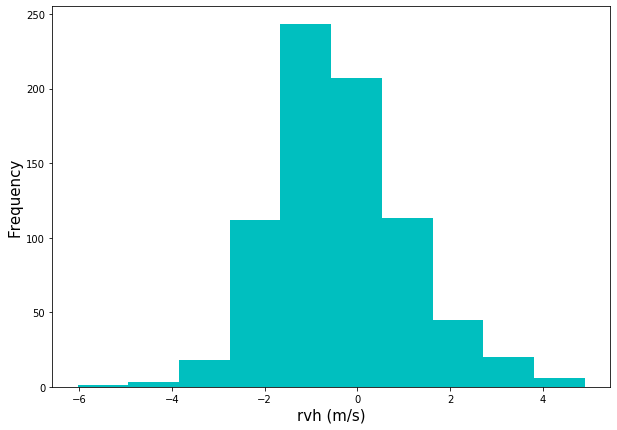

In [557]:
scaled_signals = []
for i in rv_signal_list:
    scaled_signals.append(i*1000)

fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(scaled_signals, color= "c")
ax.set_xlabel("rvh (m/s)", size = 15)
ax.set_ylabel("Frequency", size = 15)

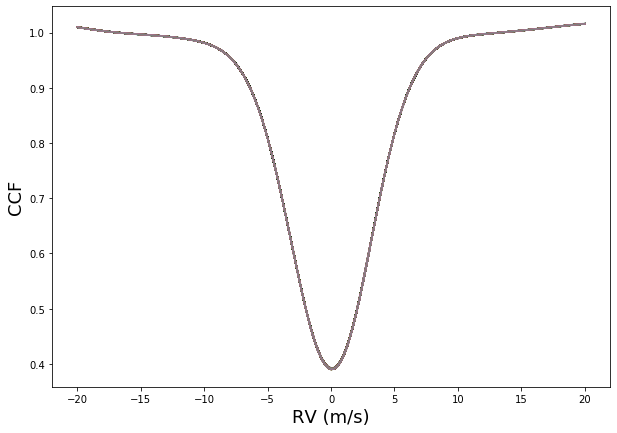

In [529]:
fig, ax = plt.subplots(figsize=(10, 7))
for i in CCF_data1_list:
    ax.plot(np.linspace(-20, 20, 161),i)
    ax.set_xlabel("RV (m/s)", size =18)
    ax.set_ylabel("CCF", size=18)

In [560]:
hdul3 = fits.open("shifted_fits_slope/shifted_fits_2019/ccf2019-12-08.fits", memmap=False)
bjd_test = hdul3[0].header["BJD"]
rv_signal = hdul3[0].header["rvh"]
CCF_data_zero = hdul3[2].data["Shifted CCF data"]
mu_zero = hdul3[0].header["MU_zero"]

hdul_quiet = fits.open("shifted_fits_slope/shifted_fits_2017/ccf2017-03-13.fits", memmap=False)
CCF_quiet = hdul_quiet[2].data["Shifted CCF data"]
print(mu_zero)
print(bjd_test)
print(rv_signal)

-0.00017713946699567
2458826.036000756
-0.00023950112048327


In [565]:
len(CCF_data1_list)

89

## Residual plots

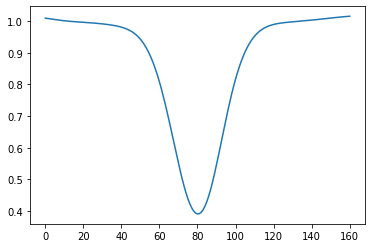

In [561]:
median_ccf = np.mean(CCF_data1_list, axis=0)
plt.plot(median_ccf)

In [671]:
# remove extreme outliers

for i in range(0, len(rv_signal_list)):
    if rv_signal_list[i]==0.006865386379104219:
        print(i)

# Make a list of the rv's withot this anomoly
rv_list_no_outliers = []
ccf_list_no_outliers = []
for i in range(0, len(rv_signal_list)):
    if i==5 or i ==45 or i ==85:#or i == 739 or i ==756 or i ==85:
        #print(ccf_num_list[i])
        continue
    rv_list_no_outliers.append(rv_signal_list[i])
    ccf_list_no_outliers.append(CCF_data1_list[i])


4


In [683]:
print(bjd_test_list[5])
print(bjd_test_list[45])
print(bjd_test_list[85])

2457237.106435021
2457292.86711829
2457385.070376353


In [532]:
#print(np.min(rv_list_no_outliers), np.max(rv_list_no_outliers))


print(np.min(rv_signal_list), np.max(rv_signal_list))
min_rv = np.min(np.array(rv_signal_list)+0.015)
max_rv = np.max(np.array(rv_signal_list)+0.015)
print(min_rv, max_rv)

-0.00675672505154642 0.007994358603170416
0.00824327494845358 0.022994358603170416


In [562]:
cscale_residuals = ((np.array(rv_signal_list)+0.015 -min_rv)/ (max_rv-min_rv))
#cscale_residuals = (np.array(np.abs(rv_signal_list))/ (-4*(max_rv+min_rv)))#-min_rv))#-0.5)/0.6
print(np.min(cscale_residuals), np.max(cscale_residuals))

0.048863001994289466 0.7907538720359989


768
768


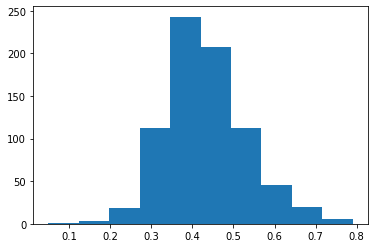

In [564]:
plt.hist(cscale_residuals)
print(len(rv_signal_list))
print(len(cscale_residuals))

In [371]:
# color code by date instead of rv
min_rv = np.min(bjd_test_list)
max_rv = np.max(bjd_test_list)
cscale_residuals = (np.array(np.abs(bjd_test_list)) -min_rv)/ (max_rv-min_rv)
print(np.min(cscale_residuals), np.max(cscale_residuals))

0.0 1.0


NameError: name 'ccf_list_no_outliers' is not defined

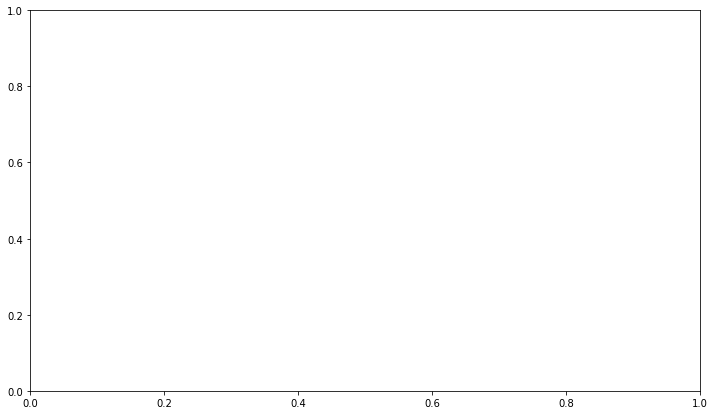

In [440]:
# Print without outliers
fig, ax = plt.subplots(figsize=(12, 7))

rv_data = np.linspace(-20, 20, 161)
#print(ccf_list[5])
#rv_list[5] is centered at 0.0

col = plt.cm.jet([0.25,0.75])
n = len(CCF_data1_list)
colors = plt.cm.bwr(cscale_residuals)


for i in range(0,len(ccf_list_no_outliers)):
    ax.plot(rv_data,ccf_list_no_outliers[i]-CCF_data_zero,  color = colors[i])

ax.set_xlabel('RV in km/s', size=20)
ax.set_ylabel('Residuals ($\Delta$CCF)', size=20)
ax.set_title("CCF Residuals from HARPS-N", size =20)
#fig.colorbar(rv_list)

Text(0.5, 1.0, 'CCF Residuals from HARPS-N')

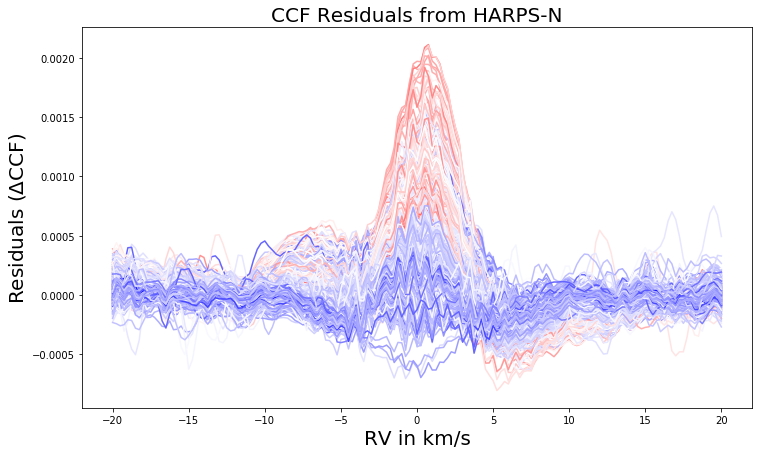

In [565]:
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(12, 7))

rv_data = np.linspace(-20, 20, 161)
#print(ccf_list[5])
#rv_list[5] is centered at 0.0

col = plt.cm.jet([0.25,0.75])
n = len(CCF_data1_list)
colors = plt.cm.bwr(cscale_residuals)


#for i in range(0,len(ccf_list)):

for i in range(0,len(CCF_data1_list)):
    mean_residual_error = np.mean(CCF_data1_list[i]-CCF_data_zero)
    #if np.abs(mean_residual_error) <5e-4:
    #    continue
    # Plot the ccf- mean_ccf
    #ax.plot(rv_data,CCF_data1_list[i]-median_ccf,  color = colors[i])
    
    # plot the ccf - quiet_ccf
    # CCF_quiet
    #ax.plot(rv_data,CCF_data1_list[i]-CCF_data_zero,  color = colors[i])
    ax.plot(rv_data,CCF_data1_list[i]-CCF_quiet,  color = colors[i])

cb1.set_label('Some Units')
ax.set_xlabel('RV in km/s', size=20)
ax.set_ylabel('Residuals ($\Delta$CCF)', size=20)
ax.set_title("CCF Residuals from HARPS-N", size =20)
#fig.colorbar(rv_list)

In [343]:
colors = plt.cm.bwr(cscale_residuals)

cmap = plt.cm.bwr
norm =mpl.colors.Normalize(vmin=-6.76, vmax=7.99) # min = -0.0067567, max = 0.007994

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Some Units')
fig.show()

/Users/Zoe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


In [406]:
mean_residual_error = np.mean(CCF_data1_list[i]-CCF_data_zero)

In [407]:
mean_residual_error

-1.742751e-05

In [305]:
a = [rv_data]
one_array.append((CCF_data1_list[i]-CCF_data_zero))

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [306]:
b = [CCF_data1_list[i]-CCF_data_zero]
c = np.concatenate((a, b))

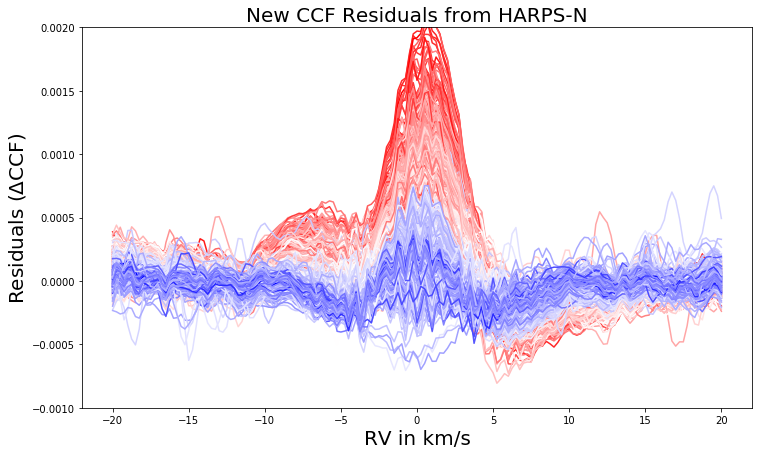

In [537]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import imageio

col = plt.cm.jet([0.25,0.75])
n = len(CCF_data1_list)
colors = plt.cm.bwr(cscale_residuals)

fig, ax = plt.subplots(figsize=(12,7))
ax.set_xlabel('RV in km/s', size=20)
ax.set_ylabel('Residuals ($\Delta$CCF)', size=20)
ax.set_title("New CCF Residuals from HARPS-N", size =20)

def plot_residuals(number):
    # Data for plotting
    rv_data = np.linspace(-20, 20, 161)

    #ax.plot(rv_data,CCF_data1_list[number]-CCF_data_zero,  color = colors[number])
    ax.plot(rv_data,CCF_data1_list[number]-CCF_quiet,  color = colors[number])
    #ax.set_xlabel('RV in km/s', size=20)
    #ax.set_ylabel('Residuals ($\Delta$CCF)', size=20)
    #ax.set_title("New CCF Residuals from HARPS-N", size =20)

    # IMPORTANT ANIMATION CODE HERE
    # Used to keep the limits constant
    ax.set_ylim(-0.001, 0.002)

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image


kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('./new_DRS_2015_2018.gif', [plot_residuals(i) for i in range(0,len(CCF_data1_list))], fps=60)

In [321]:
len(CCF_data1_list)

1079

In [302]:
b

array([ 8.20159912e-05,  4.97102737e-05,  5.47170639e-05,  9.01222229e-05,
        6.15119934e-05,  4.72068787e-05,  1.13725662e-04,  9.76324081e-05,
        6.34193420e-05,  1.20162964e-04,  1.31607056e-04,  1.03950500e-04,
        1.01685524e-04,  1.51336193e-04,  2.09212303e-04,  1.52349472e-04,
        1.51038170e-04,  1.66237354e-04,  1.39415264e-04,  9.00626183e-05,
        5.68628311e-05,  5.03063202e-05,  5.53131104e-05,  3.35574150e-05,
        5.99026680e-05,  1.41859055e-04,  1.27792358e-04,  1.24096870e-04,
        1.64449215e-04,  1.30116940e-04,  1.12831593e-04,  1.18613243e-04,
        1.25586987e-04,  1.65522099e-04,  1.56998634e-04,  1.45196915e-04,
        1.98245049e-04,  2.27034092e-04,  2.47716904e-04,  2.36809254e-04,
        2.46763229e-04,  2.50935555e-04,  2.46226788e-04,  2.90393829e-04,
        3.15308571e-04,  3.54409218e-04,  3.82781029e-04,  3.73244286e-04,
        4.06742096e-04,  4.03285027e-04,  4.10199165e-04,  4.25338745e-04,
        4.65750694e-04,  

In [304]:
c

array([-2.00000000e+01, -1.97500000e+01, -1.95000000e+01, -1.92500000e+01,
       -1.90000000e+01, -1.87500000e+01, -1.85000000e+01, -1.82500000e+01,
       -1.80000000e+01, -1.77500000e+01, -1.75000000e+01, -1.72500000e+01,
       -1.70000000e+01, -1.67500000e+01, -1.65000000e+01, -1.62500000e+01,
       -1.60000000e+01, -1.57500000e+01, -1.55000000e+01, -1.52500000e+01,
       -1.50000000e+01, -1.47500000e+01, -1.45000000e+01, -1.42500000e+01,
       -1.40000000e+01, -1.37500000e+01, -1.35000000e+01, -1.32500000e+01,
       -1.30000000e+01, -1.27500000e+01, -1.25000000e+01, -1.22500000e+01,
       -1.20000000e+01, -1.17500000e+01, -1.15000000e+01, -1.12500000e+01,
       -1.10000000e+01, -1.07500000e+01, -1.05000000e+01, -1.02500000e+01,
       -1.00000000e+01, -9.75000000e+00, -9.50000000e+00, -9.25000000e+00,
       -9.00000000e+00, -8.75000000e+00, -8.50000000e+00, -8.25000000e+00,
       -8.00000000e+00, -7.75000000e+00, -7.50000000e+00, -7.25000000e+00,
       -7.00000000e+00, -

In [291]:
one_array

array([-20.  , -19.75, -19.5 , -19.25, -19.  , -18.75, -18.5 , -18.25,
       -18.  , -17.75, -17.5 , -17.25, -17.  , -16.75, -16.5 , -16.25,
       -16.  , -15.75, -15.5 , -15.25, -15.  , -14.75, -14.5 , -14.25,
       -14.  , -13.75, -13.5 , -13.25, -13.  , -12.75, -12.5 , -12.25,
       -12.  , -11.75, -11.5 , -11.25, -11.  , -10.75, -10.5 , -10.25,
       -10.  ,  -9.75,  -9.5 ,  -9.25,  -9.  ,  -8.75,  -8.5 ,  -8.25,
        -8.  ,  -7.75,  -7.5 ,  -7.25,  -7.  ,  -6.75,  -6.5 ,  -6.25,
        -6.  ,  -5.75,  -5.5 ,  -5.25,  -5.  ,  -4.75,  -4.5 ,  -4.25,
        -4.  ,  -3.75,  -3.5 ,  -3.25,  -3.  ,  -2.75,  -2.5 ,  -2.25,
        -2.  ,  -1.75,  -1.5 ,  -1.25,  -1.  ,  -0.75,  -0.5 ,  -0.25,
         0.  ,   0.25,   0.5 ,   0.75,   1.  ,   1.25,   1.5 ,   1.75,
         2.  ,   2.25,   2.5 ,   2.75,   3.  ,   3.25,   3.5 ,   3.75,
         4.  ,   4.25,   4.5 ,   4.75,   5.  ,   5.25,   5.5 ,   5.75,
         6.  ,   6.25,   6.5 ,   6.75,   7.  ,   7.25,   7.5 ,   7.75,
      

import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
fig.set_tight_layout(True)

# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

print(fig.get_dpi())

# Plot a scatter that persists (isn't redrawn) and the initial line.
x = np.arange(0, 20, 0.1)
ax.scatter(x, x + np.random.normal(0, 3.0, len(x)))
line, = ax.plot(x, x - 5, 'r-', linewidth=2)

def update(i):
    label = 'timestep {0}'.format(i)
    print(label)
    # Update the line and the axes (with a new xlabel). Return a tuple of
    # "artists" that have to be redrawn for this frame.
    line.set_ydata(x - 5 + i)
    ax.set_xlabel(label)
    return line, ax

if __name__ == '__main__':
    # FuncAnimation will call the 'update' function for each frame; here
    # animating over 10 frames, with an interval of 200ms between frames.
    anim = FuncAnimation(fig, update, frames=np.arange(0, 10), interval=200)
    #if len(sys.argv) > 1 and sys.argv[1] == 'save':
    anim.save('line.gif', dpi=80, writer='imagemagick')
    #else:
    #    # plt.show() will just loop the animation forever.
    #    plt.show()

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


fig size: 72.0 DPI, size in inches [6. 4.]


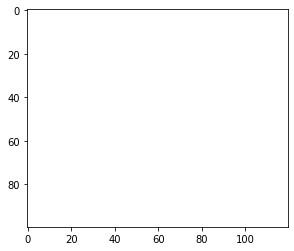

In [247]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame

ims = []
for i in range(60):
    x += np.pi / 15.
    y += np.pi / 20.
    im = plt.imshow(f(x, y), animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=False,
                                repeat_delay=1000)

print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

#To save the animation, use e.g.
#ani.save("movie.mp4")

# or
#
#from matplotlib.animation import FFMpegWriter
#writer = FFMpegWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)
#ani.save("movie.mp4", writer=writer)

#ani = FuncAnimation(fig, update, frames=np.linspace(0, 3, 128),
#                    init_func=init, blit=True)

ani.save('test.gif', dpi=72, writer='imagemagick')

plt.show()

In [283]:
type(f(x, y))

numpy.ndarray

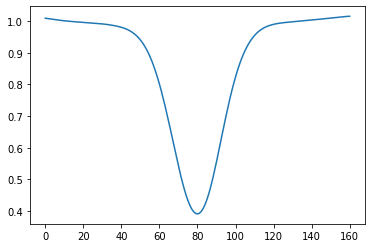

In [34]:
    files = os.listdir("shifted_fits/shifted_fits_"+str(year)+"/")
    file = files[0]
    hdul2 = fits.open(str("shifted_fits/shifted_fits_"+str(year)+"/"+file), memmap=False)
    bjd_test = hdul2[0].header["BJD"]
    #bjd_list.append(bjd_test-2400000)
    rv = hdul2[0].header["rvh"]
    #rv_list.append(rv)
    berv = hdul2[0].header["berv"]
    #berv_list.append(berv)
    vradraw = hdul2[0].header["vradraw"]
    #vradraw_list.append(vradraw)
    CCF_data = hdul2[2].data["CCF data"]
    plt.plot(CCF_data)
    

In [31]:
CCF_data = hdul2[2].data["CCF_data"]

KeyError: "Key 'CCF_data' does not exist."

In [ ]:
np.min(full_bjd_list) #2458851.91606227 = July 29, 2015
# 2019 data: January 2, 2019

In [ ]:
np.max(full_bjd_list) #2458915.96040548 = March 7, 2020
# 2019 data: December 31, 2019

In [ ]:
    # Normalize the CCF
    # no_shift fit
    p_no_shifted = [-1618490., 0.1, 1., 16730977]
    pfit_no_shift, results_no_shift = mpyfit.fit(least, p_no_shifted, (rv_axis, mean_ccf), parinfo)
    A = pfit_no_shift[0]
    C = pfit_no_shift[3]
    print(C)
    fig3, ax3 = plt.subplots(figsize=(10, 7))
    normalized_ccfa =(mean_ccf/C)
    ax3.plot(rv_axis,normalized_ccfa)

In [ ]:
!ls 'hpcstorage/buchschn/HARPN/reduced/2020-03-07'

In [ ]:
hdul = fits.open('hpcstorage/buchschn/HARPN/reduced/2020-03-07/r.HARPN.2020-03-07T09:07:49.640_CCF_A.fits', memmap=False)


In [ ]:
hdul[0].header

In [ ]:
a = hdul[1].data

In [ ]:
plt.plot(a[0])

In [ ]:
rv_data = np.linspace(-20, 20, 161)
for i in a[0:70]:
    plt.plot(rv_data,i)

In [ ]:
len(rv_data)

In [ ]:
plt.plot(hdul[1].data[69])

In [ ]:
len(a[69])

## Only first three years using old DRS rv's

In [ ]:
year = "2015"

# list the directories that have HARPS-N files in them
directories = os.listdir('hpcstorage'+str(year)+'/buchschn/HARPN/reduced')

# Open csv file with DRS RVs
df_old = pd.read_excel('../Archive_HARPS_N/Sun_harpsn_qualflag copy.xlsx')

In [ ]:
df_old['BJD']

In [ ]:
bjd

In [ ]:
directories

In [ ]:
# Finds the local minima using a Gaussian fit
# Define the actual function where     A = p[0], mu = p[1], sigma = p[2], c = p[3]
def gauss(x, p):
    return -p[0] * np.exp(-(x - p[1]) ** 2 / (2. * p[2] ** 2)) + p[3]

# A simple minimization function:
def least(p, args):
    x, y = args
    return gauss(x, p) - y

parinfo = [{'fixed': False, 'step': 1e-6},
           {'fixed': False, 'step': 1e-4},
           {'fixed': False, 'step': 1e-14},
           {'fixed': False, 'step': 1e-9}]

In [ ]:
full_bjd_list = []
removed_counter = 0
gen_counter = 0
for directory in directories:
    #print(directory)
    if directory == '.DS_Store':
        continue
    files = os.listdir(str('hpcstorage'+str(year)+'/buchschn/HARPN/reduced/'+directory))
    
    #fig, ax = plt.subplots(figsize=(10, 7))
    bjd_list =[]
    ccf_list = []
    DRS_new_vrad_list= []
    DRS_new_berv_list=[]
    rv_axis = np.linspace(-20,20, 161)
    for file in files:
        #print(file)
        hdul = fits.open(str('hpcstorage'+str(year)+'/buchschn/HARPN/reduced/'+directory+"/"+file), memmap=False)
        #print(hdul[0].header["HIERARCH TNG QC BJD"])
        ccf = hdul[1].data[69]
        bjd = hdul[0].header["HIERARCH TNG QC BJD"]-2400000
        print(bjd)
        #DRS_new_vrad = df.loc[df['new_bjd'] == bjd, 'new_vrad'].item()
        new_bjd_list = pd.Index(df_old['BJD'])
        i = new_bjd_list.get_loc(bjd, method = "nearest")
        #print(np.abs(df['new_bjd'][i]))
        
        # Check that the BJD is within 10 seconds (0.000115741 days)
        if (np.abs(df['new_bjd'][i]-bjd)) > 0.000115741:
            #print("the difference in BJD is more than 10 seconds for BJD: "+str(bjd))
            removed_counter +=1
            continue
        DRS_new_vrad= df['new_vrad'][i]
        DRS_new_berv= df['new_berv'][i]
        #ax.plot(rv_axis,ccf, color= 'b')
        
        ccf_list.append(ccf)
        bjd_list.append(bjd)
        full_bjd_list.append(bjd)
        DRS_new_vrad_list.append(DRS_new_vrad)
        DRS_new_berv_list.append(DRS_new_berv)
        #print("  - - - ")
    if not ccf_list:
        print("There are no DRS RVs on "+str(directory))
        #print(str(directory))
        continue
    mean_ccf = np.mean(ccf_list, axis=0)
    median_DRS_new_vrad = np.mean(DRS_new_vrad_list)
    median_DRS_new_berv = np.mean(DRS_new_berv_list)
    median_bjd = np.mean(bjd_list)
    #ax.plot(rv_axis,ccf, label = "all ccf's", color= 'b')
    #ax.plot(rv_axis,mean_ccf, label = "mean ccf, "+str(median_bjd), color= 'r')
    #ax.set_xlabel("RV (m/s)", size =15)
    #ax.set_ylabel("CCF", size =15)
    #ax.legend()

    #print(median_bjd)
    #print(median_DRS_new_vrad)
    
    #fig2, ax2 = plt.subplots(figsize=(10, 7))
    x_mean = [median_DRS_new_vrad]*len(DRS_new_vrad_list)
    #ax2.scatter(bjd_list,DRS_new_vrad_list, label = "all rv's", color='b')
    #ax2.plot(bjd_list,x_mean, label = "mean rv", color = 'r')
    #ax2.set_xlabel("BJD", size =15)
    #ax2.set_ylabel("DRS RV", size =15)
    #ax2.legend()
    
    # Normalize the CCF
    p_guess = [-1618490., 0.1, 1., 16730977]
    pfit, results = mpyfit.fit(least, p_guess, (rv_axis, mean_ccf), parinfo)
    A = pfit[0]
    C = pfit[3]
    #print(C)
    #fig3, ax3 = plt.subplots(figsize=(10, 7))
    normalized_ccf =(mean_ccf/C)
    #ax3.plot(rv_axis,normalized_ccf)
    
    # Write CCF, BJD, and RV to a fits file
    hdu_new = fits.ImageHDU()
    hdr = fits.Header()
    primary_hdu = fits.PrimaryHDU(header=hdr)
    hdul = fits.HDUList([primary_hdu, hdu_new])
    
    #creates columns in CCF.fits files
    #col1 = fits.Column(name='CCF data', format='E', array=normalized_ccf)
    
    hdu = fits.PrimaryHDU(normalized_ccf)
    hdulist = fits.HDUList([hdu])
    
    # Set header
    hdulist[0].header.set("BJD", median_bjd, 'Barycentric JD (from DRS)')
    hdulist[0].header.set('rvh', median_DRS_new_vrad, 'RV [km/s]')
    hdulist[0].header.set('berv', median_DRS_new_berv, 'RV [km/s]')
    
    # check whether folder exists. If not, make it
    CCF_folder_outputs = '3year_fits_'+str(year)
    if not os.path.exists(CCF_folder_outputs):
        os.mkdir(CCF_folder_outputs)
    
    # write and close hdul
    hdulist.writeto('fits_'+str(year)+'/ccf' +directory+'.fits')
    hdulist.close()
    gen_counter +=1
    if gen_counter%50==0:
        print(gen_counter)
    #print("_______")
    #if directory == "2020-02-06":
    #    break

In [ ]:
new_bjd_list = pd.Index(df_old['BJD'])

In [ ]:
i = new_bjd_list.get_loc(bjd, method = "nearest")

In [ ]:
dupes = df_old["BJD"].duplicated()

In [ ]:
count = 0
for i in dupes:
    if i != False:
        print(i)
        print(df_old["BJD"][count])
    count +=1